# Removing Background Using a Neural Network

The training dataset for the Humpback Whale Identification on Kaggle has 25,361 images.  These images are of variable size, quality and background.  


## The Problem
Cropping this many images by hand is problematic, because it is incredibly time consuming.  For completness, I attempted to remove the background on one image using the free open source image editor Gimp.  This took approxamately 5 minutes.  So it can be estimated that if one was to crop the background out of the entire training dataset it would take 126,805 minutes or roughly 88 days, provided you don't sleep, eat, or otherwise do anything but crop images.  

## Proposed Solution
Can a neural net be used to automate the work of cropping out the background on images of various size and quality?  The answer to the question is that it depends.  There are two ways to accomplish this task.

   * Train your model to recognize what is background and remove that.
   * Train your model to recognize what is a whale's tail and remove everything else.

In order to accomplish either of these tasks, the neural net needs to be able to identify what is background and what is an object.  Convolutional neural networks have been used to train object recognition models in the past.  These models can identify object types in images with many objects.  More importantly, these CNN's have been used to perform image manipulations such as drawing bounding boxes, creating a mask over the object, and labeling certain images with the object type. But these neural networks have been trained on datasets with 50,000+ images.  Which means that some number of people have gone through these large datasets and labeled these images.  Eventhough the Humpback Whale Identification dataset is only 25,000+ images, it is still too many 

So the revised question should be, can a much small number of training images be used to train a neural net model to remove the image background?  

## Software Used

The main Python modules needed for this are
   * OpenCV: A library for reading and manipulating images.
   * Numpy: For handling mulit-dimensional arrays that OpenCV will create and maniplulate.
   * Keras: A high level API for creating neural networks.
   * Tensorflow: A high level API used by Keras for creating neural networks.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
import tensorflow as tf
from keras.optimizers import Adam
from keras import backend as K
from scipy.misc import imresize
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import os
import cv2
from random import randint
import random
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
import skimage
import copy
%matplotlib inline


Using TensorFlow backend.


## Creating a Smaller Training Set

Even with a small training dataset size of 349 images, this is still a time consumming process to try to remove the background by hand.  This is where software like OpenCV can help.

### Image Thresholding in OpenCV

With image thresholding, the user will transform the image based on a set of criteria that are specified to the threshold function.  As an example, take the original black and white image below.

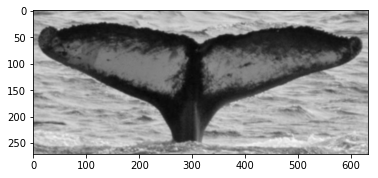

In [3]:
orig_dir = "/home/james/Kaggle/Whale/Data/train/1/"
img = cv2.imread(orig_dir + "/" + "8201ded69.jpg",0)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.show()

The human eye can easily tell where the tail is, and where the background is.  One could probably describe in detail what the background looks like, but that won't do a computer much good.  Even though the tail shows up in great detail.  The waves and surf also show up in great detail.  Which can make for a messy display.

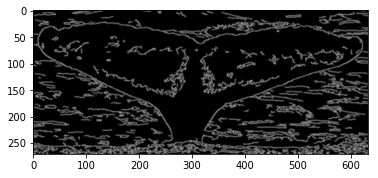

In [4]:
edges = cv2.Canny(img,100,200)
plt.imshow(edges, cmap = 'gray', interpolation = 'bicubic')
plt.show()

The human eye might be able to take a marker and draw the outline of the tail, but that description of what a tail and background, doesn't hold true anymore.  The main point in using the Canny function is to show that there are many more details in an image that may be imperceptible to the human eye, but are readily available to a computer when they are reading an image as an array of pixels. 

A technique that can be useful for sharpening lines is to run a filter over the image.  This can be done by using the filter2D function in OpenCV.  This will help later when we want to indentify the features of the tail.

In [5]:
# Sharpen Image
kernel = np.zeros( (9,9), np.float32)
kernel[4,4] = 2.0   #Identity, times two! 

#Create a box filter:
boxFilter = np.ones( (9,9), np.float32) / 81.0

#Subtract the two:
kernel = kernel - boxFilter

#Run the filter
sharpen = cv2.filter2D(img, -1, kernel)

Now a good way of cutting down unimportant features is to using a thresholding algormithm to reduce some of the background noise.  The threshold function in OpenCV will basicaly transform every pixel that meets the thresholding criteria, to a value which will be specied.  Therefore in the function call below, the threshold is set to 50, and the maximum value that will be used to replace the pixel if it falls below or above the threshold.  The last argument, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, is the type of threshold to use.  There are 6 different types of thresholding. I found that the adaptive threshold with a Gaussian window worked the best on large groups of images that vary in quality.  Therefore below, you can see what the threshold looks like

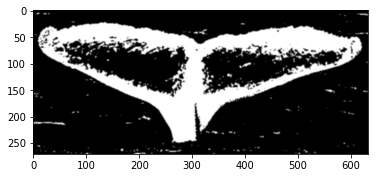

In [6]:
ret,thresh = cv2.threshold(sharpen,70,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C)
plt.imshow(thresh, cmap = 'gray', interpolation = 'bicubic')
plt.show()

Now a computer should be able to outline the whale tail.  This can be done with OpenCV and it's findContours function.  This function will take the threshold value above and try to find the contours of the image.

In [7]:
_,contours,hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

So now we have a list of contours that the findContours function was able to find.  So now all that has to be done is to find the biggest contour.

In [8]:
contour_shape = {}
i = 0
for contour in contours:
    if contour.shape[0] > 500:
        contour_shape[contour.shape[0]] = i
    i += 1

contour_shape_keys = sorted(contour_shape)
try:
    c = contours[contour_shape[contour_shape_keys[-1]]]
except:
    print("Can't do:", file)

Then all that has to be done is to fill in this contour with black pixels and everything that is not a black pixel, convert them to white pixels.  This will yield a mask that has the tail pixels in black and the background in white.

In [9]:
mask = copy.deepcopy(img)
cv2.drawContours(mask,[c],-1,(0,0,0),-1)
mask[mask != 0] = 255

So why is it important to create a mask?  Image masking allows us to essentially create an array where the shape of the tail is represented in black pixels (0,0,0) and white pixels are represented as (255,255,255).  Every other color falls between those two values.  When you have a numpy array containing 300 by 500 pixels, you can subtract the mask from the original image and this will essentially remove all of the background.  For example if you have a background pixel that is red (255,0,0), and you subract it from the mask, which has put the background at (255,255,255), you get a pixel that is (0,-255,-255), which essential converted to (0,0,0). Therefore every pixel in the background gets converted to a black pixel.  This can be done easily enough with OpenCV's subtract function.

In [10]:
masked_image = cv2.subtract(img,mask)

| Original Image | Mask | Masked Image |
| ---- | ---- | ---- |
|![](images/8201ded69-orig.jpg)|![](images/8201ded69-mask.jpg)|![](images/8201ded69-masked_image.jpg)|

In [11]:
edges2 = cv2.Canny(masked_image,100,200)

If we examine the canniness of the new image compared to the canniness of the the old image shows just how many features were removed.  Features that had nothing to do with the tail.

| Original Canny  | Canny After Masked Image |
| ---- | ---- |
|![](images/8201ded69-edges1.jpg)|![](images/8201ded69-edges2.jpg)|

This looks pretty great right?  So why don't we do this for all the images and just forget about the Neural Network in general?  This is because the thresholding algorithm can't take into account the overall brightness of the image.  It can't take into account when the tail is white already or black.  The next image illustrates this example.

| Original Image | Mask | Masked Image |
| ---- | ---- | ---- |
|![](images/9074c1b18-orig.jpg)|![](images/9074c1b18-mask.jpg)|![](images/9074c1b18-masked_image.jpg)|

So using thresholding and finding countours methods from OpenCV can't get all the masks, mostly because the images quality ranges from terrible to very clear.  However, this method will correctly get 10% of the masks.  You can run the above thresholding algorithm on all 25000+ images and then flip through them manually and select the ones that worked properly.  This is not an exact science, but it is much better then using Gimp to do them by hand.

## Using a Neural Network to Predict Image Masks

After using thresholding and filling countours using OpenCV, there where 349 masks that were created sucessfully.  This is a very small training data set for working with a CNN, therefore a regular CNN won't be an option. 

U-Nets have several advantages over regular convolutional neural netowrks.  First, the U-net works well with relatively few images.  Second, they have the ability to use the softmax activation function in the output layer to predict a pixel wise represention for the target label.So in a U-net model, like a regular CNN, the original image are used as the input features.  In contrast to a regular CNN, the target labels for a U-Net are the 349 image masks that were created above [2].


Building a U-net involves two specific sets of convolutional layers:
   1. Building what looks like a normal convolutional neural network using a series of constricting layers  with maxpooling functions.  The iput layer conforms to the input size of the data, like most neural networks.  Each subsequent layer is downsampled, and maxpooling operations are applied. 
   2. The last half of the U-net is a set of convolutional layers that are upsampled.  This allows for higher resolution  and propagation of context information to the subsequent layers.



### Reading the Images into Memory

Now that you have as small training data set, place the masks into a directory, and the original images into another directory.  Then get the names of all the images into a list so they can be accessed when all of the images are looped over.

In [10]:
# set the necessary directories
data_dir = "/home/james/Kaggle/Whale/Data/train/masks/2/masks_real/"
mask_dir = "/home/james/Kaggle/Whale/Data/train/masks/2/masks_train/"

train_images = os.listdir(data_dir)
train_length = len(train_images)

Neural networks need a standardized input and the above images are of various sizes.  So a definition of a standard height and width will be needed so that the images can be resized.

In [11]:
height=256
width=256

When dealing with images, it is a good idea to create a function that can augment your existing data set.  This accomplishes two things.  First, it helps increase the overall size of your dataset, so that your network has a chance to learn over more data.  Secondly, it helps reduce overfitting by creating images that are slightly different than the originals.

In [13]:
def image_augment(image,mask):
    
    random_int = randint(0,4)
    
    if random_int == 0:
        # We only want to do a small amount of these.
        # Try to randomly flip both image and mask.
        intflip =  randint(0,5)
        if intflip == 0:
            image = cv2.flip(image, 0)
            mask = cv2.flip(mask,0)
        elif intflip == 1:
            image = cv2.flip(image, 1)
            mask = cv2.flip(mask,1)
        # Else don't do anything
    
    if random_int == 0 or random_int == 1 or random_int == 2:
        # Introduce some noise
        sigma = randint(0, 50)
        temp_image = np.float64(np.copy(image))
        h = temp_image.shape[0]
        w = temp_image.shape[1]
        noise = np.random.randn(h, w) * sigma

        noisy_image = np.zeros(temp_image.shape, np.float64)
        if len(temp_image.shape) == 2:
            noisy_image = temp_image + noise
        else:
            noisy_image[:,:,0] = temp_image[:,:,0] + noise
            noisy_image[:,:,1] = temp_image[:,:,1] + noise
            noisy_image[:,:,2] = temp_image[:,:,2] + noise  
        
        image = noisy_image
    
    # Scale In
    if random_int == 2 or random_int == 3:
        scale = random.uniform(0.1, 0.9)
        #print(image.shape)
        height,width,channel = image.shape
        scale_out = skimage.transform.rescale(image, scale=scale, mode='constant')
        resized_image = cv2.resize(scale_out, (width, height))
        
        scale_out = skimage.transform.rescale(mask, scale=scale, mode='constant')
        resized_mask = cv2.resize(scale_out, (width, height))
        
        image = resized_image
        mask = resized_mask
    
    # Scale Out
    if random_int == 0 or random_int == 1:
        scale = random.uniform(1.1, 2.2)
        
        #print(image.shape)
        height,width,channel = image.shape
        scale_out = skimage.transform.rescale(image, scale=scale, mode='constant')
        resized_image = cv2.resize(scale_out, (width, height))
        
        scale_out = skimage.transform.rescale(mask, scale=scale, mode='constant')
        resized_mask = cv2.resize(scale_out, (width, height))
        
        image = resized_image
        mask = resized_mask
    
    
    return image,mask

Once the images are identifed, they need to be read into memory, so they can be fed into the fitting function.  The below function should suffice.

In [14]:
def read_image(img_dir,msk_dir,image,mask,dims):
    
    original_img = load_img(img_dir + image)
    resized_img = imresize(original_img, dims+[3])
    array_img = img_to_array(resized_img)/255
    
    original_mask = load_img(msk_dir + image)
    resized_mask = imresize(original_mask, dims+[3])
    array_mask = img_to_array(resized_mask)/255    
    
    array_img,array_mask = image_augment(array_img,array_mask)
    
    return array_img,array_mask

When dealing with images, it is a good idea to create a function to read the data in.  The below function will be executed by Keras during each step when the model is fit.

In [16]:
def image_reader(data_dir, mask_dir, images, batch_size, dims):

        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                # images
                array_img,array_mask = read_image(data_dir,mask_dir,images[i],images[i].split(".")[0] + '.jpg',dims)
                imgs.append(array_img)
                labels.append(array_mask[:, :, 0])
                
            imgs = np.array(imgs)
            labels = np.array(labels)
            
            # return both the images and the masks to the main program 
            yield imgs, labels.reshape(-1, dims[0], dims[1], 1)

The code found below was taken from another Kaggle submission and can be found <a href="https://www.kaggle.com/ecobill/u-nets-with-keras">here</a>.  The basic premise is that two different types of layers are instantiated, and two functions can be made to decrease code reuse.

In [17]:
def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(input_layer)
    residual = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    return conv2

#### The Input Layer

In [ ]:
filters = 64
input_layer = Input(shape = [height, width, 3])
layers = [input_layer]
residuals = []

#### The downsampling path

In [18]:
d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2

d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2

d3, res3 = down(d2, filters)
residuals.append(res3)

filters *= 2

d4, res4 = down(d3, filters)
residuals.append(res4)

filters *= 2

d5 = down(d4, filters, pool=False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

#### The Upsampling Path

In [ ]:
up1 = up(d5, residual=residuals[-1], filters=filters/2)

filters /= 2

up2 = up(up1, residual=residuals[-2], filters=filters/2)

filters /= 2

up3 = up(up2, residual=residuals[-3], filters=filters/2)

filters /= 2

up4 = up(up3, residual=residuals[-4], filters=filters/2)

####  The Output Layer

In [ ]:
out = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(up4)

model = Model(input_layer, out)

model.summary()

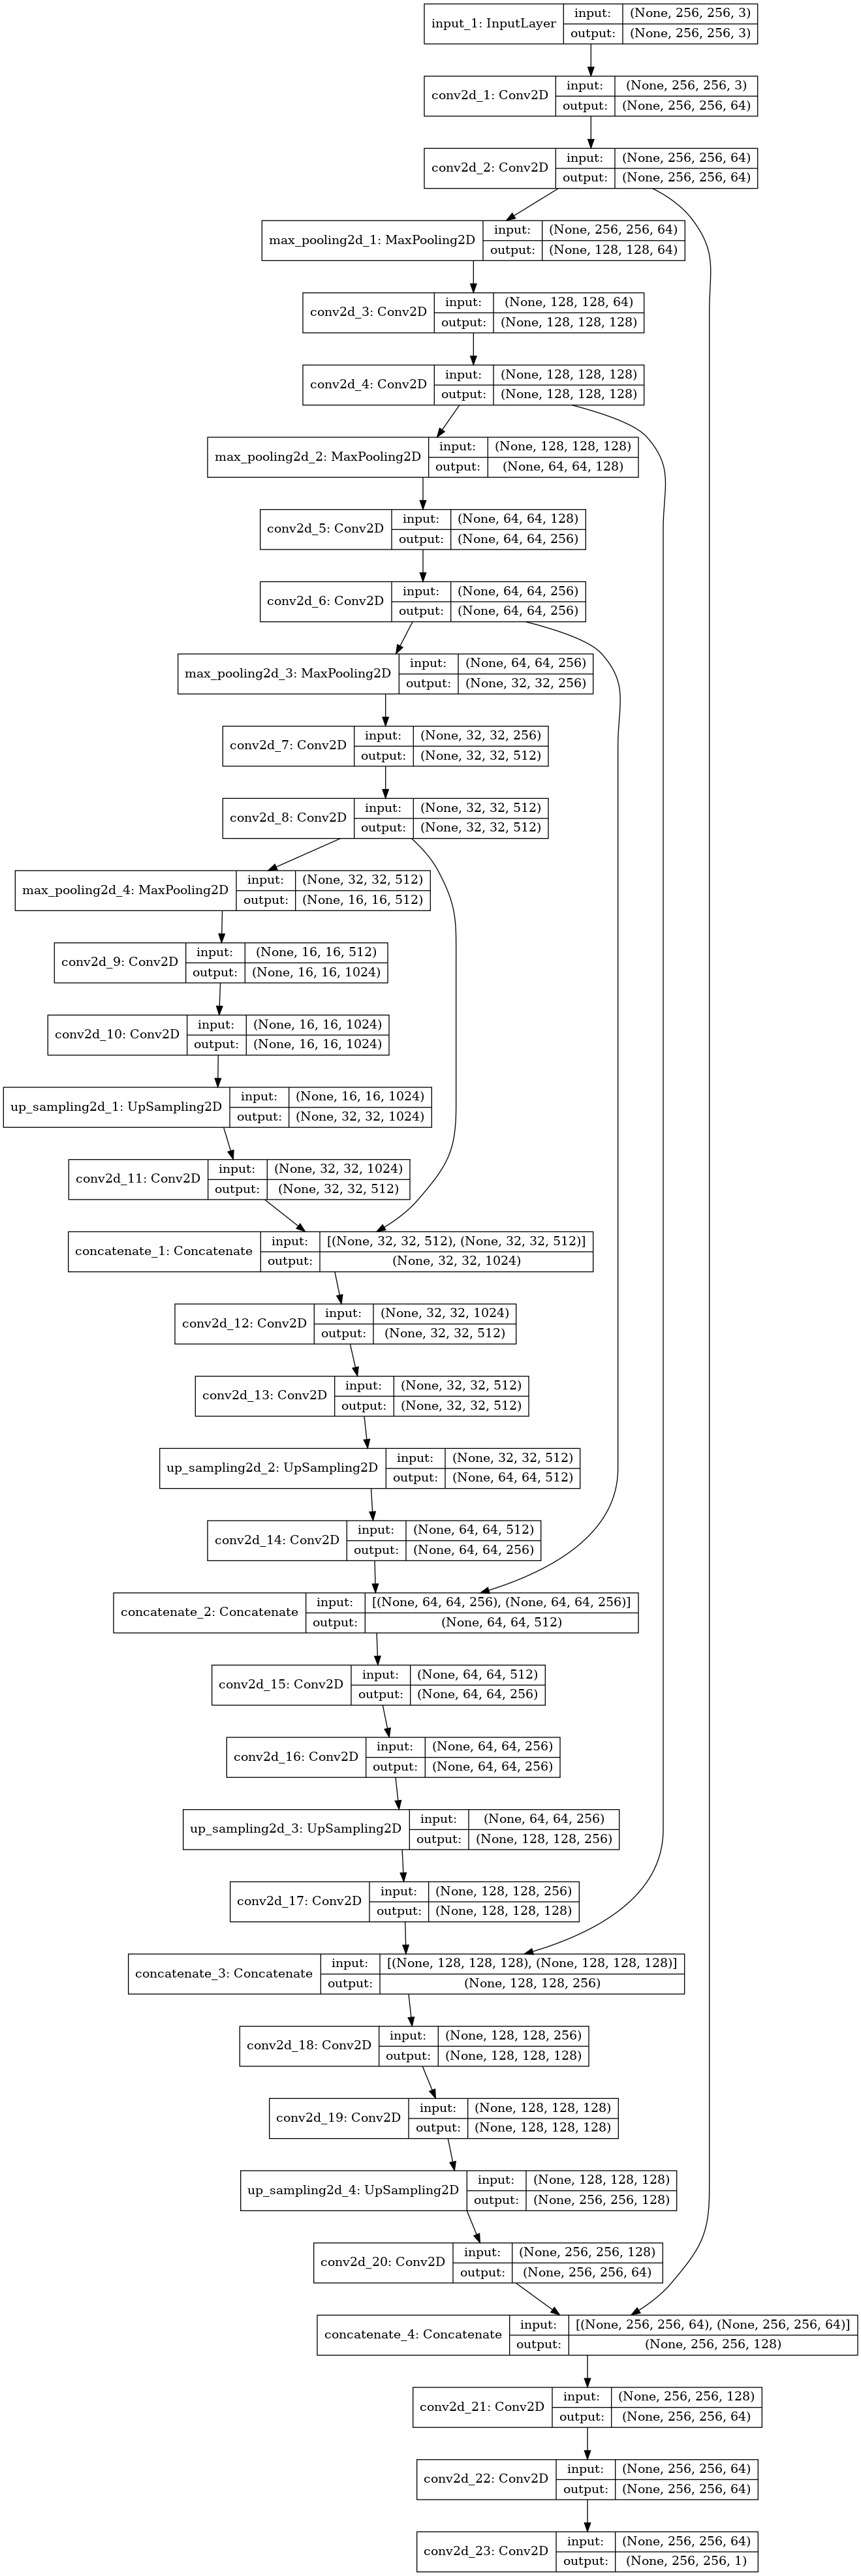

In [19]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

Dice coefficient is often used in image segmentation to predict masks for images [3].  It can be written using the GPU optizations in the Keras backend, in this case Tensorflow.  Keras provides api calls to the backends for the round() and reshape() functions in Tensorflow.  However, it has not yet implemented the reduce_sum() function, so we must drop down to using Tensor flow directly. 

In [20]:
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = K.round(K.reshape(y_true, [-1]))
    y_pred = K.round(K.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

It is best practice to use the Keras check pointing ability so that the best model can be saved to a file and loaded later on.  Also if the training gets interupted it can be restarted without loosing the already completed epochs.

In [21]:
filepath="/home/james/Kaggle/Whale/Data/train/whales-masks" + ".best.hdf5"

checkpoint = ModelCheckpoint(filepath, 
                             monitor="dice_coef",
                             verbose=0, 
                             save_best_only=True, 
                             mode='max')


callbacks_list = [checkpoint]

Now compile the model with Adam as the optimizer, and using the dice_coef function written above as the metric.

In [ ]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef])

And instantiate the the image reader function as an object so it can be called by the fit_generator() function in Keras.

In [ ]:
train_gen = image_reader(data_dir, mask_dir, train_images, 5,[height, width])

All that is left to do is just train the model and record the statistics in a variable called history which will allow us to graph the loss and dice coeficient results at each epoch.

In [25]:
history = model.fit_generator(train_gen, 
                    steps_per_epoch=100, 
                    epochs=600,
                    callbacks=callbacks_list,
                    verbose=0
                   )

Epoch 1/1500


/usr/local/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.
/usr/local/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


100/100 [==============================] - 57s 574ms/step - loss: 0.0971 - dice_coef: 0.9715

Epoch 00001: dice_coef did not improve from 0.97648
Epoch 2/1500
100/100 [==============================] - 58s 582ms/step - loss: 0.0868 - dice_coef: 0.9752

Epoch 00002: dice_coef did not improve from 0.97648
Epoch 3/1500
100/100 [==============================] - 58s 585ms/step - loss: 0.0879 - dice_coef: 0.9748

Epoch 00003: dice_coef did not improve from 0.97648
Epoch 4/1500
100/100 [==============================] - 58s 585ms/step - loss: 0.0944 - dice_coef: 0.9721

Epoch 00004: dice_coef did not improve from 0.97648
Epoch 5/1500
100/100 [==============================] - 59s 587ms/step - loss: 0.0958 - dice_coef: 0.9717

Epoch 00005: dice_coef did not improve from 0.97648
Epoch 6/1500
100/100 [==============================] - 59s 586ms/step - loss: 0.0812 - dice_coef: 0.9770

Epoch 00006: dice_coef improved from 0.97648 to 0.97695, saving model to /home/james/Kaggle/Whale/Data/train/wh

100/100 [==============================] - 59s 589ms/step - loss: 0.0988 - dice_coef: 0.9709

Epoch 00051: dice_coef did not improve from 0.98050
Epoch 52/1500
100/100 [==============================] - 59s 589ms/step - loss: 0.0861 - dice_coef: 0.9754

Epoch 00052: dice_coef did not improve from 0.98050
Epoch 53/1500
100/100 [==============================] - 59s 589ms/step - loss: 0.0925 - dice_coef: 0.9735

Epoch 00053: dice_coef did not improve from 0.98050
Epoch 54/1500
100/100 [==============================] - 59s 588ms/step - loss: 0.1056 - dice_coef: 0.9693

Epoch 00054: dice_coef did not improve from 0.98050
Epoch 55/1500
100/100 [==============================] - 59s 589ms/step - loss: 0.0950 - dice_coef: 0.9722

Epoch 00055: dice_coef did not improve from 0.98050
Epoch 56/1500
100/100 [==============================] - 59s 588ms/step - loss: 0.0929 - dice_coef: 0.9733

Epoch 00056: dice_coef did not improve from 0.98050
Epoch 57/1500
100/100 [==============================]

100/100 [==============================] - 59s 588ms/step - loss: 0.0864 - dice_coef: 0.9753

Epoch 00153: dice_coef did not improve from 0.98050
Epoch 154/1500
100/100 [==============================] - 59s 588ms/step - loss: 0.1030 - dice_coef: 0.9696

Epoch 00154: dice_coef did not improve from 0.98050
Epoch 155/1500
100/100 [==============================] - 59s 588ms/step - loss: 0.0914 - dice_coef: 0.9737

Epoch 00155: dice_coef did not improve from 0.98050
Epoch 156/1500
100/100 [==============================] - 59s 589ms/step - loss: 0.0827 - dice_coef: 0.9759

Epoch 00156: dice_coef did not improve from 0.98050
Epoch 157/1500
100/100 [==============================] - 59s 589ms/step - loss: 0.0922 - dice_coef: 0.9737

Epoch 00157: dice_coef did not improve from 0.98050
Epoch 158/1500
100/100 [==============================] - 59s 589ms/step - loss: 0.0809 - dice_coef: 0.9771

Epoch 00158: dice_coef did not improve from 0.98050
Epoch 159/1500
100/100 [=========================

100/100 [==============================] - 59s 588ms/step - loss: 0.0822 - dice_coef: 0.9766

Epoch 00204: dice_coef did not improve from 0.98050
Epoch 205/1500
100/100 [==============================] - 59s 588ms/step - loss: 0.0919 - dice_coef: 0.9734

Epoch 00205: dice_coef did not improve from 0.98050
Epoch 206/1500
100/100 [==============================] - 59s 588ms/step - loss: 0.0852 - dice_coef: 0.9754

Epoch 00206: dice_coef did not improve from 0.98050
Epoch 207/1500
100/100 [==============================] - 59s 588ms/step - loss: 0.0897 - dice_coef: 0.9743

Epoch 00207: dice_coef did not improve from 0.98050
Epoch 208/1500
100/100 [==============================] - 59s 588ms/step - loss: 0.0784 - dice_coef: 0.9780

Epoch 00208: dice_coef did not improve from 0.98050
Epoch 209/1500
100/100 [==============================] - 59s 587ms/step - loss: 0.0850 - dice_coef: 0.9753

Epoch 00209: dice_coef did not improve from 0.98050
Epoch 210/1500
100/100 [=========================

100/100 [==============================] - 59s 588ms/step - loss: 0.0966 - dice_coef: 0.9715

Epoch 00304: dice_coef did not improve from 0.98130
Epoch 305/1500
100/100 [==============================] - 59s 588ms/step - loss: 0.0949 - dice_coef: 0.9723

Epoch 00305: dice_coef did not improve from 0.98130
Epoch 306/1500
100/100 [==============================] - 59s 588ms/step - loss: 0.0738 - dice_coef: 0.9794

Epoch 00306: dice_coef did not improve from 0.98130
Epoch 307/1500
100/100 [==============================] - 59s 590ms/step - loss: 0.0777 - dice_coef: 0.9785

Epoch 00307: dice_coef did not improve from 0.98130
Epoch 308/1500
100/100 [==============================] - 59s 588ms/step - loss: 0.0830 - dice_coef: 0.9759

Epoch 00308: dice_coef did not improve from 0.98130
Epoch 309/1500
100/100 [==============================] - 59s 589ms/step - loss: 0.0956 - dice_coef: 0.9727

Epoch 00309: dice_coef did not improve from 0.98130
Epoch 310/1500
100/100 [=========================

100/100 [==============================] - 59s 589ms/step - loss: 0.0933 - dice_coef: 0.9734

Epoch 00355: dice_coef did not improve from 0.98130
Epoch 356/1500
100/100 [==============================] - 59s 587ms/step - loss: 0.0934 - dice_coef: 0.9733

Epoch 00356: dice_coef did not improve from 0.98130
Epoch 357/1500
100/100 [==============================] - 59s 588ms/step - loss: 0.0850 - dice_coef: 0.9761

Epoch 00357: dice_coef did not improve from 0.98130
Epoch 358/1500
100/100 [==============================] - 59s 587ms/step - loss: 0.0922 - dice_coef: 0.9737

Epoch 00358: dice_coef did not improve from 0.98130
Epoch 359/1500
100/100 [==============================] - 59s 587ms/step - loss: 0.0798 - dice_coef: 0.9779

Epoch 00359: dice_coef did not improve from 0.98130
Epoch 360/1500
100/100 [==============================] - 59s 588ms/step - loss: 0.0904 - dice_coef: 0.9738

Epoch 00360: dice_coef did not improve from 0.98130
Epoch 361/1500
100/100 [=========================

100/100 [==============================] - 59s 588ms/step - loss: 0.0919 - dice_coef: 0.9731

Epoch 00406: dice_coef did not improve from 0.98130
Epoch 407/1500
100/100 [==============================] - 59s 587ms/step - loss: 0.0929 - dice_coef: 0.9727

Epoch 00407: dice_coef did not improve from 0.98130
Epoch 408/1500
100/100 [==============================] - 59s 588ms/step - loss: 0.0910 - dice_coef: 0.9736

Epoch 00408: dice_coef did not improve from 0.98130
Epoch 409/1500
100/100 [==============================] - 59s 588ms/step - loss: 0.0959 - dice_coef: 0.9720

Epoch 00409: dice_coef did not improve from 0.98130
Epoch 410/1500
100/100 [==============================] - 59s 590ms/step - loss: 0.0843 - dice_coef: 0.9759

Epoch 00410: dice_coef did not improve from 0.98130
Epoch 411/1500
100/100 [==============================] - 59s 589ms/step - loss: 0.0771 - dice_coef: 0.9787

Epoch 00411: dice_coef did not improve from 0.98130
Epoch 412/1500
100/100 [=========================

100/100 [==============================] - 59s 588ms/step - loss: 0.0817 - dice_coef: 0.9769

Epoch 00457: dice_coef did not improve from 0.98130
Epoch 458/1500
100/100 [==============================] - 59s 589ms/step - loss: 0.0897 - dice_coef: 0.9738

Epoch 00458: dice_coef did not improve from 0.98130
Epoch 459/1500
100/100 [==============================] - 59s 588ms/step - loss: 0.0782 - dice_coef: 0.9785

Epoch 00459: dice_coef did not improve from 0.98130
Epoch 460/1500
100/100 [==============================] - 59s 588ms/step - loss: 0.0886 - dice_coef: 0.9748

Epoch 00460: dice_coef did not improve from 0.98130
Epoch 461/1500
100/100 [==============================] - 59s 588ms/step - loss: 0.0849 - dice_coef: 0.9755

Epoch 00461: dice_coef did not improve from 0.98130
Epoch 462/1500
100/100 [==============================] - 59s 587ms/step - loss: 0.0868 - dice_coef: 0.9757

Epoch 00462: dice_coef did not improve from 0.98130
Epoch 463/1500
100/100 [=========================

KeyboardInterrupt: 

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.show()

## How Well Does it Work?


| Original Image | Mask | Masked Image |
| ---- | ---- | ---- |
|![](images/9074c1b18-orig.jpg)|![](images/9074c1b18-nn-mask.jpg)|![](images/9074c1b18-nn-masked.jpg)|


In [26]:
origdir = "/home/james/Kaggle/Whale/Data/train/1/"
origmasksdir = "/home/james/Kaggle/Whale/Data/train/masks_all/"
origmaskimgdir = "/home/james/Kaggle/Whale/Data/train/masked_img/"
# Get all the image names into a list
test_images = os.listdir(origdir)
test_images.sort()

In [ ]:
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img

In [ ]:
def read_test(img_dir,image,dims):
    
    original_img = load_img(img_dir + image)
    resized_img = imresize(original_img, dims+[3])
    array_img = img_to_array(resized_img)/255

    
    return array_img

The image_reader function used above in the model.fit_generator can be used again to create an array of test images.

In [27]:
test_len = len(test_images)
# load best performing model
model.load_weights(filepath)

i=0
for filename in test_images:
    print(filename)
    image = read_test(origdir,filename,[height,width])
    
    image = image.reshape(-1, height, width, 3)
    prediction = model.predict(image)
    prediction = prediction.reshape(height,width, 1)
    prediction = grey2rgb(prediction)

    
    
    # Get the original image with now resizing
    orig_image = cv2.imread(origdir + filename,3)
    #plt.imshow(orig_image,cmap = 'gray', interpolation = 'bicubic')
    #plt.show()
    
    orig_height = orig_image.shape[0]
    orig_width = orig_image.shape[1]
    # Convert the prediction mask to the same size as original image
    orig_mask = cv2.resize(prediction, (orig_width,orig_height))
    
    
    orig_mask[orig_mask > .5] = 255
    orig_mask[orig_mask < .5] = 0
    orig_mask = orig_mask.astype("uint8")
    
    #plt.imshow(orig_mask,cmap = 'gray', interpolation = 'bicubic')
    #plt.show()

    background_image = cv2.subtract(orig_image,orig_mask)
    #plt.imshow(background_image,cmap = 'gray', interpolation = 'bicubic')
    #plt.show()
    
    cv2.imwrite(origmasksdir + filename, orig_mask)
    cv2.imwrite(origmaskimgdir + filename, background_image)

    #if i == 100:
    #    break
    i+=1





0000e88ab.jpg


/usr/local/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


0001f9222.jpg
00029d126.jpg
00050a15a.jpg
0005c1ef8.jpg
0006e997e.jpg
000a6daec.jpg
000f0f2bf.jpg
0016b897a.jpg
001c1ac5f.jpg
001cae55b.jpg
001d7450c.jpg
00200e115.jpg
00245a598.jpg
002b4615d.jpg
002f99f01.jpg
00355ff28.jpg
00357e37a.jpg
003795857.jpg
0041880bf.jpg
0043da555.jpg
00442c882.jpg
00464ff65.jpg
004775679.jpg
004ae9e26.jpg
004c0f43b.jpg
004e8ad5b.jpg
004f87702.jpg
0050ef29d.jpg
00514c876.jpg
0052ce2f5.jpg
00537ec91.jpg
00570db6b.jpg
005ce3100.jpg
00600ce17.jpg
006017ddf.jpg
0060f764a.jpg
006500b3d.jpg
006506edf.jpg
0067b3a20.jpg
006bdc6ff.jpg
00713060e.jpg
007218187.jpg
0073118da.jpg
007a7846f.jpg
007b62e05.jpg
007f3eb46.jpg
008124524.jpg
0084fe40b.jpg
0085064af.jpg
0085a6bd0.jpg
00869b59e.jpg
008bf89fc.jpg
008ebc50d.jpg
00910010d.jpg
00917baa4.jpg
0093454b6.jpg
009431af0.jpg
009589b45.jpg
0095fe89c.jpg
00961802f.jpg
009687166.jpg
0096c8ff3.jpg
009c45bc7.jpg
00a3dd76f.jpg
00a46c559.jpg
00a4de95e.jpg
00a70e649.jpg
00a9dc47d.jpg
00aae723d.jpg
00b7ffb8a.jpg
00b92e9bf.jpg
00bc4d

05d5db36c.jpg
05d6517f2.jpg
05d71e676.jpg
05d9cc57a.jpg
05da28fcb.jpg
05dae8342.jpg
05db04583.jpg
05dd0ee6b.jpg
05dfa3773.jpg
05e5e0e89.jpg
05e81e346.jpg
05ea19d75.jpg
05ea2c861.jpg
05ed57e10.jpg
05ee04d0c.jpg
05ee1fc22.jpg
05eeabf1b.jpg
05f2f037c.jpg
05f71b26a.jpg
05fc2e35d.jpg
060bacbc7.jpg
060ffd336.jpg
0610203d1.jpg
0611099f3.jpg
06119661c.jpg
0613a4aa9.jpg
0616cbd68.jpg
06171a8a9.jpg
06172ce2c.jpg
0617ca20a.jpg
0617cbeed.jpg
0618f6c38.jpg
061996245.jpg
061f833ab.jpg
06209926d.jpg
06245ed98.jpg
062699bef.jpg
06276874e.jpg
0628d4679.jpg
062d0bd7e.jpg
06306504e.jpg
06307bbf6.jpg
0631db372.jpg
06336bf78.jpg
0633e8c04.jpg
063759573.jpg
06389a1fc.jpg
0638c9ae1.jpg
063d5700d.jpg
063e89413.jpg
064bafe62.jpg
064dd41a3.jpg
064de9c50.jpg
06504fa5b.jpg
0654b3e5b.jpg
065b72556.jpg
065fbc00f.jpg
066074afc.jpg
066228078.jpg
066c039dc.jpg
0670b3636.jpg
0679f42ec.jpg
067cdde9d.jpg
067d80626.jpg
068062d67.jpg
0680aab46.jpg
06822966b.jpg
06848f3e1.jpg
0689a1032.jpg
068f9cdba.jpg
06907cb5c.jpg
06948b

0b92d79c0.jpg
0b961a0e2.jpg
0b9c56e0e.jpg
0b9e0d549.jpg
0ba05e099.jpg
0ba0e60f3.jpg
0ba1d8367.jpg
0ba2fe848.jpg
0ba3bb92d.jpg
0baa89964.jpg
0bb23359d.jpg
0bb469e7d.jpg
0bb5b9ae5.jpg
0bb67e44d.jpg
0bbf8f60a.jpg
0bc10f0f7.jpg
0bc2ff714.jpg
0bc4ab015.jpg
0bc500118.jpg
0bc8f5788.jpg
0bcb4b53a.jpg
0bcb9fc34.jpg
0bd1610f8.jpg
0bd64cea3.jpg
0bd65a44d.jpg
0bd7ff74f.jpg
0bda0c14f.jpg
0be63cacd.jpg
0be68a06b.jpg
0be897d0d.jpg
0bece9363.jpg
0bee24cfb.jpg
0bef01d4e.jpg
0bf303ed2.jpg
0bf8136cf.jpg
0bf9730f8.jpg
0bf980011.jpg
0c005aa88.jpg
0c037e179.jpg
0c057c0a6.jpg
0c076e252.jpg
0c08a4d6d.jpg
0c08f0cb6.jpg
0c0bf8fb8.jpg
0c0cea389.jpg
0c115fd9c.jpg
0c146080d.jpg
0c15936e3.jpg
0c166f137.jpg
0c18eda1c.jpg
0c1960aa4.jpg
0c19af6d4.jpg
0c1af7d67.jpg
0c2379d8a.jpg
0c25ed201.jpg
0c2653d9e.jpg
0c2adec98.jpg
0c30517d8.jpg
0c3197e04.jpg
0c341777d.jpg
0c36db7c9.jpg
0c3822f8c.jpg
0c39bd7ff.jpg
0c3afa7cd.jpg
0c3b7d753.jpg
0c401f637.jpg
0c44e92d7.jpg
0c45bf60f.jpg
0c4b0827e.jpg
0c4cf7f5d.jpg
0c508bef1.jpg
0c5147

11b442a49.jpg
11b51a782.jpg
11b619eca.jpg
11b9716d2.jpg
11c1054cf.jpg
11c3065f2.jpg
11c5985dd.jpg
11c839069.jpg
11c985217.jpg
11cd20bbc.jpg
11ceb760d.jpg
11d39fc43.jpg
11d57cd9c.jpg
11df60816.jpg
11e29e5e2.jpg
11e370e11.jpg
11e3ea5f6.jpg
11e7f96c5.jpg
11e907470.jpg
11edd672b.jpg
11f476f56.jpg
11f591047.jpg
11f59c2b3.jpg
11f98ade5.jpg
11fc1d26c.jpg
1202f27b4.jpg
12035e558.jpg
12037f781.jpg
1204c90d2.jpg
12093d2aa.jpg
120bbc906.jpg
120f5245d.jpg
12126d255.jpg
121819c9a.jpg
12184a9dc.jpg
121880d7f.jpg
121a7c56b.jpg
121db0677.jpg
121e3acc2.jpg
121e713b1.jpg
1222fa72b.jpg
1226da218.jpg
122d0e026.jpg
122f497db.jpg
122fbab73.jpg
1232d5324.jpg
1235eb22c.jpg
1236b667c.jpg
1239463f4.jpg
123b794ba.jpg
1242405d7.jpg
124254cb7.jpg
1244ce135.jpg
124913ed3.jpg
124a0e40a.jpg
124b1ef2d.jpg
12509a8e1.jpg
12518411d.jpg
1255a88bc.jpg
125869ae7.jpg
125b7d50d.jpg
125ba1407.jpg
125c6370c.jpg
126002936.jpg
1262321e3.jpg
1262dba60.jpg
12670516b.jpg
1268ef193.jpg
126e44013.jpg
126fc51b0.jpg
1270df73e.jpg
1272df

1802f4d47.jpg
180380bcc.jpg
18063def0.jpg
180a18d6e.jpg
180e98c54.jpg
181020979.jpg
181115c88.jpg
1812eeb95.jpg
181677b84.jpg
1818cfcbb.jpg
181ecc608.jpg
181fd95f4.jpg
182110c20.jpg
1822b7c68.jpg
18234111f.jpg
1825014de.jpg
18251a799.jpg
1829ac06d.jpg
182ac1bf2.jpg
182d5e290.jpg
18322eb9f.jpg
1837eedd8.jpg
183ae60da.jpg
18459a654.jpg
1845b343b.jpg
1847e87ee.jpg
184b85d7d.jpg
1850b6e39.jpg
18554c028.jpg
1855dac14.jpg
1860fb96e.jpg
1867e30c2.jpg
1868691a1.jpg
186dc4deb.jpg
1871a772e.jpg
1873d094a.jpg
18746ba21.jpg
1876ff23d.jpg
18780491e.jpg
187bb1839.jpg
1883237ff.jpg
188616175.jpg
1887a9835.jpg
188b04c45.jpg
188e5e66e.jpg
188f220f2.jpg
1891111cf.jpg
1892d17c2.jpg
1895c79c5.jpg
189a97d50.jpg
189b44a9d.jpg
189d5937b.jpg
189d85e90.jpg
18a26f162.jpg
18a278983.jpg
18a35d725.jpg
18a618c6b.jpg
18a6a8885.jpg
18a6dceea.jpg
18a73e2ee.jpg
18aae894c.jpg
18af303c2.jpg
18b2cfff5.jpg
18b36c8dc.jpg
18b39de07.jpg
18b7adcfa.jpg
18b9ebd3c.jpg
18bc422ca.jpg
18c3f55d6.jpg
18c7549fe.jpg
18c7f0c14.jpg
18ce3a

1e210d936.jpg
1e246b8da.jpg
1e29532df.jpg
1e2c317a7.jpg
1e2f9b457.jpg
1e305701a.jpg
1e38164a7.jpg
1e38ba8e7.jpg
1e38e1550.jpg
1e3f3af7f.jpg
1e44b642c.jpg
1e44fc47a.jpg
1e4617d24.jpg
1e49df4d4.jpg
1e4b4581c.jpg
1e4b60cdd.jpg
1e4b8c2cf.jpg
1e4dfe5d2.jpg
1e4e80b25.jpg
1e51290a9.jpg
1e5296b34.jpg
1e555128e.jpg
1e55ac126.jpg
1e58763df.jpg
1e592515e.jpg
1e5c68b0c.jpg
1e5e7b47a.jpg
1e603228d.jpg
1e6555ae4.jpg
1e65fef55.jpg
1e6952f12.jpg
1e69ad0e3.jpg
1e6a260b7.jpg
1e6a774fa.jpg
1e7271c12.jpg
1e73ca94a.jpg
1e73f3ede.jpg
1e762d038.jpg
1e78cdeb7.jpg
1e795c3d3.jpg
1e7a69eb8.jpg
1e7d9a510.jpg
1e85fdd1a.jpg
1e8b51160.jpg
1e8c1aa9f.jpg
1e8eec843.jpg
1e8f91b2c.jpg
1e9244dbe.jpg
1e97d5520.jpg
1e9aa4f1f.jpg
1e9ca6e57.jpg
1ea3df0b4.jpg
1ea4dca23.jpg
1ea766b42.jpg
1ea98999c.jpg
1ead12359.jpg
1eafa2bb4.jpg
1eb26eedd.jpg
1eb6554f3.jpg
1eb6ae4a6.jpg
1eb7a0671.jpg
1eb881661.jpg
1eb8b1f2d.jpg
1eb8eff24.jpg
1eb98f3be.jpg
1ebc69e97.jpg
1ec00b281.jpg
1ec04cc20.jpg
1ec0d128c.jpg
1ec170983.jpg
1ec863e20.jpg
1eccad

241c16bd3.jpg
241e38166.jpg
241fa79b9.jpg
242213b95.jpg
242238017.jpg
24225d859.jpg
2423c2da1.jpg
2423f48c1.jpg
24263e2e1.jpg
2426d1e5b.jpg
2427b1a3e.jpg
242a7f02b.jpg
242b46917.jpg
242f501ae.jpg
24310205b.jpg
243170b1b.jpg
2433348f1.jpg
243452737.jpg
2436e0e0f.jpg
243c9c87a.jpg
24402c6ac.jpg
2444c6ed3.jpg
244878f4f.jpg
245132f75.jpg
2453a6e65.jpg
2453c4631.jpg
2453dea33.jpg
24554c576.jpg
24579acdd.jpg
24587f7ed.jpg
245929082.jpg
245d27ea7.jpg
2463ec2a1.jpg
2464b5d43.jpg
24687d4e7.jpg
246a212f9.jpg
246a41d63.jpg
2470463d6.jpg
24712d686.jpg
247285a8d.jpg
24735fde4.jpg
2477ca3e8.jpg
247af9a7f.jpg
247e00dd7.jpg
24812755a.jpg
24813b7b9.jpg
24832c240.jpg
24885f014.jpg
248d3cd30.jpg
249045450.jpg
24921f77f.jpg
249481d7a.jpg
249583568.jpg
2496034e3.jpg
2496b8260.jpg
249f34fee.jpg
24a22415a.jpg
24a25d87b.jpg
24a29bb09.jpg
24a2d3fee.jpg
24a8edab4.jpg
24acea2d6.jpg
24af3682a.jpg
24b338103.jpg
24b409c38.jpg
24bd87f8d.jpg
24c1871b2.jpg
24c21121e.jpg
24c4dcc8b.jpg
24c68d5a3.jpg
24cb7c3e5.jpg
24cdd5

2a2cf502d.jpg
2a3023480.jpg
2a32b5011.jpg
2a339c434.jpg
2a340adf9.jpg
2a360f126.jpg
2a3613f4c.jpg
2a3df73dc.jpg
2a43a82c2.jpg
2a4510df9.jpg
2a4c8fcec.jpg
2a4e00ced.jpg
2a50449a9.jpg
2a54d72ea.jpg
2a594f207.jpg
2a5ac6133.jpg
2a5b2c31b.jpg
2a5f11848.jpg
2a61ed8cb.jpg
2a64fb056.jpg
2a653051a.jpg
2a65fac07.jpg
2a662973d.jpg
2a6782bb6.jpg
2a68af5ef.jpg
2a6b64f49.jpg
2a7172f00.jpg
2a720ecaa.jpg
2a744ee56.jpg
2a754e737.jpg
2a83780cb.jpg
2a8590b22.jpg
2a882f692.jpg
2a88d800a.jpg
2a8a16648.jpg
2a8f8289f.jpg
2a953477d.jpg
2a982b13b.jpg
2a9d5c279.jpg
2a9fce3d4.jpg
2a9fffbe6.jpg
2aa194f2f.jpg
2aa31dfa9.jpg
2aa548710.jpg
2aa6c7c04.jpg
2aab8d75c.jpg
2ab28a9b3.jpg
2ab3c0183.jpg
2ab410d32.jpg
2ab725d17.jpg
2ab8644ab.jpg
2aba33900.jpg
2aba65b94.jpg
2abfd1165.jpg
2ac19e867.jpg
2ac31f6fe.jpg
2ac3aff55.jpg
2ac595429.jpg
2aca22775.jpg
2acffdf4d.jpg
2ad0fd10f.jpg
2adadead5.jpg
2adbe5139.jpg
2add23160.jpg
2adf3e32e.jpg
2ae0a3a09.jpg
2ae1ca8e5.jpg
2ae2236ad.jpg
2ae368ab0.jpg
2ae61890a.jpg
2aea3c3da.jpg
2aeaff

2fea245f4.jpg
2fecc4c6d.jpg
2fedfe3ad.jpg
2fee6864f.jpg
2ff7687ea.jpg
2ff97413b.jpg
2ff988b9f.jpg
2ffa31138.jpg
2ffd3e80b.jpg
2ffd5ba97.jpg
30086e5a2.jpg
3008be490.jpg
300cf57a9.jpg
300eedf90.jpg
300f6e1cf.jpg
301653731.jpg
301b722fb.jpg
301be5b59.jpg
302108859.jpg
3022969e9.jpg
30271875f.jpg
302786c5d.jpg
302802011.jpg
302821f39.jpg
302a55053.jpg
30313cca2.jpg
3032488ef.jpg
303938df6.jpg
3039c91e5.jpg
303af19d7.jpg
303c19e56.jpg
303cbcbf6.jpg
303def2a3.jpg
303f7a4de.jpg
303fd8876.jpg
3040781e5.jpg
3041a3534.jpg
3042fbbfe.jpg
30452a68d.jpg
30471a388.jpg
305015649.jpg
3060de673.jpg
306198d1e.jpg
30624307c.jpg
30669294a.jpg
306733c15.jpg
306981bb3.jpg
306a035a1.jpg
306e29b2d.jpg
3071bc26f.jpg
3073d859e.jpg
307a82f97.jpg
308067dd3.jpg
30823c79e.jpg
3082ad4b1.jpg
30837e498.jpg
3084591fc.jpg
30847d905.jpg
3090d3069.jpg
30927d598.jpg
309b8afaa.jpg
309fa9c3a.jpg
30a64fe34.jpg
30a9973af.jpg
30aa68312.jpg
30ad0808d.jpg
30b462e55.jpg
30b5dc0b9.jpg
30bd700a3.jpg
30bed8ec9.jpg
30c1d5731.jpg
30c4c4

3606ea8b7.jpg
360715bdd.jpg
360a0d7d9.jpg
360a3a9d0.jpg
360bb6720.jpg
360c25b2b.jpg
360e1ce66.jpg
36129cf58.jpg
3612c5daf.jpg
3618fc309.jpg
361f2e9cb.jpg
3621d86a6.jpg
3623eae7a.jpg
3624091e0.jpg
3626c328e.jpg
362733513.jpg
362884102.jpg
362b56294.jpg
363110c4b.jpg
363169733.jpg
36337445a.jpg
3634d474b.jpg
3635aff02.jpg
363890e2f.jpg
363bad2ff.jpg
363ea3eca.jpg
3641717ad.jpg
364b4d9d5.jpg
364dd86d0.jpg
364f468af.jpg
364f75bf0.jpg
3653d500a.jpg
3657250e6.jpg
3659134a2.jpg
365f722dd.jpg
3662b6586.jpg
3667336e7.jpg
3669a356a.jpg
3669c86dd.jpg
366cfc070.jpg
367150343.jpg
3671adf0d.jpg
3673a0bc5.jpg
36770d9c3.jpg
367b8f052.jpg
367bb9fa7.jpg
367d2fe78.jpg
368365f40.jpg
368733de2.jpg
36875e12d.jpg
3689bbea9.jpg
368c1d011.jpg
368cfd705.jpg
368d1fcf7.jpg
36935beb9.jpg
3695b69d3.jpg
36972a2ed.jpg
36995599f.jpg
369bb52ed.jpg
369bbbcbf.jpg
369de80e0.jpg
369ed0645.jpg
36a055e3f.jpg
36a1e4e76.jpg
36a526aab.jpg
36a833f0a.jpg
36a84c071.jpg
36a93d72d.jpg
36aa1c73f.jpg
36af454c6.jpg
36b00587b.jpg
36b2d7

3c14f4eae.jpg
3c159d5d6.jpg
3c1ca5824.jpg
3c1f7fe58.jpg
3c216cb93.jpg
3c23285f9.jpg
3c257bca6.jpg
3c2c8b566.jpg
3c3393e26.jpg
3c34f0ebc.jpg
3c35ab685.jpg
3c3713488.jpg
3c38a0c7b.jpg
3c3ad9832.jpg
3c3d65b40.jpg
3c4235ad2.jpg
3c45fbb5b.jpg
3c46dc47c.jpg
3c48c62c2.jpg
3c553cff2.jpg
3c590a2d9.jpg
3c5ad708e.jpg
3c5bbc211.jpg
3c5d86b2a.jpg
3c731d8bd.jpg
3c7b51d15.jpg
3c81b70f4.jpg
3c8256238.jpg
3c8685029.jpg
3c87a722e.jpg
3c89b9105.jpg
3c8a8b718.jpg
3c8c1f7b3.jpg
3c8c68129.jpg
3c8e569cd.jpg
3c8e7258b.jpg
3c8f87463.jpg
3c90ae279.jpg
3c999ac78.jpg
3c99f9aef.jpg
3c9ccb9b5.jpg
3c9da89b6.jpg
3c9f6d426.jpg
3ca17bd73.jpg
3ca31ebd4.jpg
3ca357852.jpg
3cac77232.jpg
3cac7aed2.jpg
3cad1ad01.jpg
3cb040c0a.jpg
3cb24a6dd.jpg
3cb42d44b.jpg
3cb56f16e.jpg
3cb958ffd.jpg
3cba09780.jpg
3cbb9bb68.jpg
3cbc2e21a.jpg
3cbeb4d4a.jpg
3cbf65786.jpg
3cc647668.jpg
3cc71e9cc.jpg
3cc817781.jpg
3cc8cd1f2.jpg
3ccb3c187.jpg
3cce47a65.jpg
3ccfa4891.jpg
3cd0217f2.jpg
3cd47c00f.jpg
3cd5bc725.jpg
3cd6c9ac5.jpg
3cd828778.jpg
3cd924

41c978e42.jpg
41ca7dcb8.jpg
41cf6fd14.jpg
41d561a2d.jpg
41d801432.jpg
41de18c90.jpg
41de36d5e.jpg
41de42aa7.jpg
41df98a50.jpg
41e355f7c.jpg
41e398a98.jpg
41e73eb57.jpg
41ef21153.jpg
41f7d1047.jpg
41fb1eb8a.jpg
41fed9cca.jpg
42020c994.jpg
4206f5114.jpg
4209bf0d9.jpg
420ad8215.jpg
420cc3ace.jpg
420e0e2f2.jpg
4212a3e1f.jpg
421312968.jpg
4213288c7.jpg
4214483ad.jpg
42150d155.jpg
4217039a6.jpg
4218095f9.jpg
421a5c978.jpg
421a764b4.jpg
421e93330.jpg
4220d13cf.jpg
422102670.jpg
42227afa6.jpg
422992064.jpg
422b49d19.jpg
422cfcdb3.jpg
422e1b58c.jpg
422e2a81d.jpg
4236edec6.jpg
4237c8fbe.jpg
42394e8bc.jpg
423ffd2c9.jpg
424689c9d.jpg
4246ec2b7.jpg
424a1defe.jpg
425611ea4.jpg
42575e722.jpg
425ac1cad.jpg
425b445da.jpg
425d03aef.jpg
425e8dc0c.jpg
425f763ca.jpg
4266e8df0.jpg
42673cfac.jpg
4267f88ab.jpg
4268fd0b3.jpg
42699c49e.jpg
426a28a9a.jpg
426a79122.jpg
426bd892f.jpg
426e7691a.jpg
4271c3ecc.jpg
4273282ff.jpg
4275b9298.jpg
42808c2d7.jpg
4280b266c.jpg
428146202.jpg
42817f75a.jpg
428b43417.jpg
428bf5

474e7aec8.jpg
474f3876e.jpg
475500ed1.jpg
475831893.jpg
4759d4aea.jpg
475e6f089.jpg
4761786c2.jpg
4761f87f2.jpg
47678ad87.jpg
476a0bdc8.jpg
476bfc1ec.jpg
476c2eb33.jpg
476cfbf4d.jpg
4771764bb.jpg
477317dbe.jpg
477539719.jpg
477bcf0f1.jpg
477ec0f89.jpg
477ee1c68.jpg
477fbae2b.jpg
4780ad614.jpg
4780b9c6a.jpg
4780dabe8.jpg
47847493c.jpg
478549f50.jpg
4785d33ff.jpg
47877d568.jpg
478a6a14c.jpg
478d3d5f5.jpg
478de5b6e.jpg
479307df9.jpg
47a1e0a6e.jpg
47a7dc6a9.jpg
47a93852a.jpg
47aceec14.jpg
47af8181e.jpg
47b1dd8b5.jpg
47b82f263.jpg
47b93577b.jpg
47b9c75d8.jpg
47bd1d3bb.jpg
47c4329e5.jpg
47cc2fa0a.jpg
47cc7b788.jpg
47cfc0f01.jpg
47d1582fc.jpg
47d2741ad.jpg
47d45971a.jpg
47d503102.jpg
47d77f7c9.jpg
47d949260.jpg
47d99aed9.jpg
47d9ad983.jpg
47dd731bc.jpg
47e04b769.jpg
47e0583c6.jpg
47e17af86.jpg
47e35f740.jpg
47e3c24dd.jpg
47e71881d.jpg
47e8f9e96.jpg
47eb9f93d.jpg
47ec9f6dc.jpg
47ed8ff8c.jpg
47ef1eae1.jpg
47f3035d5.jpg
47f583530.jpg
47f63a55d.jpg
47f67d28c.jpg
47f88ae6c.jpg
47fb03609.jpg
47ff23

4d3141425.jpg
4d316e82e.jpg
4d33cec45.jpg
4d36abc45.jpg
4d378a0b2.jpg
4d478723a.jpg
4d4bf22c9.jpg
4d4cfd4a8.jpg
4d4d85fba.jpg
4d4f4ad11.jpg
4d503bc95.jpg
4d54fee74.jpg
4d5a2a26a.jpg
4d5d6461e.jpg
4d5e0a310.jpg
4d5e2d509.jpg
4d6002e1f.jpg
4d630f1ce.jpg
4d668f23b.jpg
4d6d63d92.jpg
4d7262a1e.jpg
4d7655942.jpg
4d7807a96.jpg
4d783a79c.jpg
4d784d3c0.jpg
4d7ad0c3a.jpg
4d7ae7ecc.jpg
4d7b41bb0.jpg
4d7bbc98b.jpg
4d8113e69.jpg
4d811f646.jpg
4d8214aaa.jpg
4d830aee3.jpg
4d83389ad.jpg
4d8da1776.jpg
4d92c21b7.jpg
4d93919c9.jpg
4d9488f38.jpg
4d97e54b7.jpg
4d99624f9.jpg
4d9c4a1a0.jpg
4d9e8172d.jpg
4d9fc178b.jpg
4da030702.jpg
4da3cf9ac.jpg
4da42e23a.jpg
4da6b3c6b.jpg
4da77a44d.jpg
4da84bff4.jpg
4dacd08ab.jpg
4db0c011a.jpg
4db20e526.jpg
4db51e355.jpg
4db8c61cd.jpg
4dbdd08b8.jpg
4dc2ef835.jpg
4dc36d838.jpg
4dc665d8f.jpg
4dc6796d4.jpg
4dc67d9b2.jpg
4dcf6412b.jpg
4dd08c554.jpg
4dd20c3b3.jpg
4dd4d6c7b.jpg
4dd7de9b0.jpg
4dd80d851.jpg
4dd81ac01.jpg
4dd9f1877.jpg
4dda2d639.jpg
4ddeeedf6.jpg
4de03f8ab.jpg
4de32a

532211939.jpg
532468dab.jpg
53293c1ea.jpg
532a3fe5f.jpg
532c79a37.jpg
532cbc031.jpg
533150966.jpg
5331dca6a.jpg
533329c32.jpg
533504534.jpg
5336ac99b.jpg
533871394.jpg
533f96782.jpg
534001e4c.jpg
534093323.jpg
534284730.jpg
5342e53d1.jpg
53476f77b.jpg
534ab659f.jpg
5353216d6.jpg
53540b6f2.jpg
5354272d6.jpg
53565e549.jpg
5357d3ab6.jpg
535a611be.jpg
535ed8a87.jpg
535f23a66.jpg
53613fa13.jpg
5361efb51.jpg
5363327d6.jpg
53669dd83.jpg
536905f44.jpg
536b3aeaa.jpg
5373691d4.jpg
5374d2558.jpg
537b6b9a8.jpg
5381c7ed3.jpg
5389be923.jpg
538eb9102.jpg
538f9f498.jpg
5390152f0.jpg
5391283ef.jpg
539272960.jpg
53950d512.jpg
53952ef60.jpg
53968ca4d.jpg
5396a7034.jpg
539c7cfcd.jpg
53a3ead5f.jpg
53ae827ab.jpg
53afe1a89.jpg
53b3c5ab9.jpg
53b845b3b.jpg
53bb428e9.jpg
53bb483de.jpg
53be367a4.jpg
53bef22bb.jpg
53c11c462.jpg
53c155eaa.jpg
53c38d05a.jpg
53c483ab5.jpg
53cb1c9b1.jpg
53d158a3b.jpg
53d217348.jpg
53d478023.jpg
53d82969e.jpg
53d84ff28.jpg
53d9c8700.jpg
53dbcaa94.jpg
53e1560fd.jpg
53e242bd9.jpg
53e84a

5963f163c.jpg
5966e9e70.jpg
5968f72be.jpg
596c89820.jpg
596ed9430.jpg
596f341e5.jpg
596fe9828.jpg
5970d9bbd.jpg
597122e6c.jpg
597e61c4b.jpg
597f2d162.jpg
5984c200c.jpg
5987b75dd.jpg
598efe3f2.jpg
598f1e614.jpg
59917a789.jpg
5992204a9.jpg
5993e9c5a.jpg
5997c5756.jpg
599941f8d.jpg
599c47954.jpg
599d99d80.jpg
599f3f2e3.jpg
59a149ef2.jpg
59a1a821c.jpg
59a1d21e3.jpg
59ab9ca5c.jpg
59ac1a67c.jpg
59acd323e.jpg
59b302402.jpg
59b4167ff.jpg
59b93962b.jpg
59b958888.jpg
59c282b8f.jpg
59c2c8e2a.jpg
59c361dc7.jpg
59c788f3e.jpg
59c88c3b8.jpg
59cb87622.jpg
59ced9f36.jpg
59d03644f.jpg
59d36b57e.jpg
59d39d538.jpg
59d3b62b9.jpg
59d7a9b49.jpg
59db3dea3.jpg
59dcbad4b.jpg
59e185d0c.jpg
59e375b85.jpg
59e87bd82.jpg
59ec87583.jpg
59f1dcb97.jpg
59f21e395.jpg
59f533487.jpg
59f5adc38.jpg
59fa2f74e.jpg
59fbee13c.jpg
59fca0fda.jpg
59fedaded.jpg
5a02bb81b.jpg
5a04494a6.jpg
5a0968b12.jpg
5a0c448f0.jpg
5a0c47114.jpg
5a0e09e88.jpg
5a0ed048f.jpg
5a1018b0c.jpg
5a10260eb.jpg
5a122bd98.jpg
5a17f640b.jpg
5a18b6471.jpg
5a1959

5ef4a4300.jpg
5ef945925.jpg
5efaee481.jpg
5f00a5173.jpg
5f0438122.jpg
5f050b3a4.jpg
5f07ed369.jpg
5f0936434.jpg
5f0af2f92.jpg
5f0b6cfa3.jpg
5f0e182ea.jpg
5f0f46291.jpg
5f115fa0e.jpg
5f173de32.jpg
5f17896ab.jpg
5f1b7de72.jpg
5f200cf92.jpg
5f24f43e7.jpg
5f25db7f4.jpg
5f26b9f9e.jpg
5f2927dec.jpg
5f2a2acb0.jpg
5f2d60bce.jpg
5f2fe570c.jpg
5f32a0733.jpg
5f34a1b24.jpg
5f37a8fb3.jpg
5f37d323c.jpg
5f3c9207e.jpg
5f3d8e945.jpg
5f41af399.jpg
5f420b231.jpg
5f43ede60.jpg
5f447e972.jpg
5f4977d49.jpg
5f4b305ed.jpg
5f4c0523b.jpg
5f4c92e28.jpg
5f4c98e03.jpg
5f5493d11.jpg
5f5b7b5da.jpg
5f5ecbb72.jpg
5f6050057.jpg
5f6a07058.jpg
5f72227dc.jpg
5f73a747a.jpg
5f759afee.jpg
5f79edcaa.jpg
5f7bd6d42.jpg
5f7be169b.jpg
5f7c835bd.jpg
5f81bd0c2.jpg
5f83a23c5.jpg
5f85a5f8a.jpg
5f8929046.jpg
5f8a4623f.jpg
5f8d68179.jpg
5f8dd9935.jpg
5f943c2af.jpg
5f94e63e2.jpg
5f95c4dc2.jpg
5f9d88a4e.jpg
5fa077c35.jpg
5fa518bea.jpg
5fa595e4d.jpg
5fa65bf31.jpg
5fa7b78d5.jpg
5faa8ae71.jpg
5fb0f54e1.jpg
5fb3e2653.jpg
5fb476931.jpg
5fb6bb

64e58af46.jpg
64e5d768d.jpg
64e6bf920.jpg
64e762ce4.jpg
64e7c9d9b.jpg
64e832cf4.jpg
64e933d66.jpg
64ec05373.jpg
64ef03f10.jpg
64ef9788e.jpg
64fac1e25.jpg
64fc5e880.jpg
64fc84bb8.jpg
64fd8b71b.jpg
650000c54.jpg
6505aba3d.jpg
6506c3345.jpg
650a68fec.jpg
651054e6f.jpg
65131b5fc.jpg
6516fdf9a.jpg
651711175.jpg
651bef009.jpg
651dce4fb.jpg
651f18b4a.jpg
652621f54.jpg
6529a7b9f.jpg
652a37678.jpg
6535a602e.jpg
6536b8895.jpg
6537a423e.jpg
65388f5b6.jpg
6538ef17f.jpg
653b3b0e3.jpg
6545ebf73.jpg
65461842c.jpg
65486b0cf.jpg
654951f81.jpg
654d1ea2e.jpg
654d926ec.jpg
654f36363.jpg
6552c55d6.jpg
65558bf45.jpg
6555bf506.jpg
655abe9c9.jpg
655ad753e.jpg
655bd57fc.jpg
655c0cd09.jpg
655dd7e47.jpg
655e1dcd6.jpg
655e5b607.jpg
655f1f15b.jpg
656178a56.jpg
65661b7c0.jpg
656e70e61.jpg
657385c03.jpg
657aae64d.jpg
657bb73ce.jpg
657c743f5.jpg
6580da83f.jpg
65812d529.jpg
6584e147f.jpg
658575742.jpg
658664764.jpg
659087602.jpg
6592a0450.jpg
659583f73.jpg
6598ec053.jpg
659b605a1.jpg
659d01e65.jpg
65a248f54.jpg
65a6d0

6ad776e8c.jpg
6addb54df.jpg
6ae00a3c0.jpg
6ae0bb582.jpg
6ae0d3865.jpg
6ae2c4a7e.jpg
6ae34d783.jpg
6aec27e8a.jpg
6aec280ba.jpg
6aee29bfb.jpg
6af30a730.jpg
6af6dbf5a.jpg
6af72aed4.jpg
6afe358e1.jpg
6b00580cc.jpg
6b0180ef3.jpg
6b049fd9e.jpg
6b0ceced3.jpg
6b0e212e6.jpg
6b1638031.jpg
6b1d9f480.jpg
6b28f10db.jpg
6b2923dbe.jpg
6b29760e3.jpg
6b2e23dcf.jpg
6b2eadccd.jpg
6b31b9009.jpg
6b35da87b.jpg
6b37a7176.jpg
6b3933a3a.jpg
6b3db19ad.jpg
6b4309d0c.jpg
6b438993c.jpg
6b47065b0.jpg
6b49dd09c.jpg
6b49effe0.jpg
6b4a04695.jpg
6b4de6fcd.jpg
6b4e30aba.jpg
6b51326b9.jpg
6b543d3ef.jpg
6b554e9ae.jpg
6b579a3ef.jpg
6b57a2817.jpg
6b5f01cde.jpg
6b609cdf2.jpg
6b651ce77.jpg
6b674012a.jpg
6b687d6ed.jpg
6b6959e1a.jpg
6b6a581bf.jpg
6b6c1e835.jpg
6b6c74cc4.jpg
6b711b679.jpg
6b743bbf3.jpg
6b7488071.jpg
6b74f2430.jpg
6b7763c82.jpg
6b778ae7a.jpg
6b790d0a7.jpg
6b7998430.jpg
6b7acbf59.jpg
6b7d944fc.jpg
6b7edd56a.jpg
6b82d9418.jpg
6b83274ed.jpg
6b8a6d5c4.jpg
6b8beae46.jpg
6b94bc7a2.jpg
6b9bb2564.jpg
6b9c54328.jpg
6b9ccf

710efd139.jpg
710f0cb50.jpg
7111d3e8c.jpg
71125b7fa.jpg
71127fee5.jpg
71148b1fc.jpg
7116ce45e.jpg
71181b84c.jpg
711c3827e.jpg
71284f298.jpg
7128fab23.jpg
712ab6b71.jpg
712ac8d5c.jpg
712fc66f5.jpg
713274294.jpg
71340e044.jpg
7134919c7.jpg
7134a447c.jpg
713ba2cf4.jpg
714129951.jpg
71418eab9.jpg
71487a063.jpg
714880628.jpg
7149b850e.jpg
714d74f90.jpg
714da58bc.jpg
714f9e566.jpg
71517547a.jpg
71564d091.jpg
71567f036.jpg
7158ce855.jpg
715d5c287.jpg
7160003c5.jpg
716082ef8.jpg
7160e18d5.jpg
71620fa91.jpg
7164278eb.jpg
716776748.jpg
7168171ca.jpg
7169e7251.jpg
716d3d957.jpg
716dab0bb.jpg
716e01e08.jpg
716f109e1.jpg
716f6f462.jpg
71706ea66.jpg
7171b73d6.jpg
7174d0ad9.jpg
7186c0b33.jpg
718b5d204.jpg
7192f0fe4.jpg
7195384da.jpg
719811ff4.jpg
719a2e03e.jpg
719dc0255.jpg
71a0c3d2b.jpg
71a49fb9f.jpg
71a56a0d4.jpg
71a74dcb0.jpg
71a93ef28.jpg
71aa05981.jpg
71aec5a1e.jpg
71afedd03.jpg
71b00cc8e.jpg
71b29f9a5.jpg
71b308f82.jpg
71b9dfe83.jpg
71bbacbf3.jpg
71bff494b.jpg
71c67bb31.jpg
71c7a966d.jpg
71c8dc

77186ceb6.jpg
771965136.jpg
7719ad65f.jpg
771a65be2.jpg
771c98d56.jpg
771ebe2aa.jpg
771fbd42c.jpg
7723dc3fd.jpg
772734376.jpg
77275dee4.jpg
772d81906.jpg
772e2102b.jpg
772f213bc.jpg
772f83e0a.jpg
7734bb428.jpg
773772bba.jpg
773809515.jpg
773996d67.jpg
773c603c1.jpg
773e5c024.jpg
7740dfeb6.jpg
774247c73.jpg
7742e1ef6.jpg
7742e489f.jpg
774560b4d.jpg
77459570d.jpg
7745ac318.jpg
774b30e59.jpg
774b9f306.jpg
774cf1702.jpg
7752c50de.jpg
7757114dc.jpg
775e2885f.jpg
77628071f.jpg
7763eda02.jpg
7765326f5.jpg
77670be6b.jpg
77674d4e4.jpg
776a26ca3.jpg
776e67327.jpg
776ee30d0.jpg
77708a3a4.jpg
7770971fa.jpg
7770ea437.jpg
77714a6a5.jpg
77738baf5.jpg
777ab7ad2.jpg
777b15ad7.jpg
777c305a4.jpg
777c8095e.jpg
777f5e138.jpg
77825443c.jpg
77833e1ad.jpg
778524ef9.jpg
7785db7f2.jpg
778c922c3.jpg
778fc5b5f.jpg
7796b3b95.jpg
77977d043.jpg
7798cad6e.jpg
77998a8e4.jpg
779cc8aa7.jpg
779d8a353.jpg
779fb45f0.jpg
77a1b6741.jpg
77a44bf94.jpg
77a5d0fa1.jpg
77a865f06.jpg
77a90b174.jpg
77a9547fd.jpg
77a9bd9be.jpg
77b0e2

7c94005c1.jpg
7c96c95c7.jpg
7c9825c01.jpg
7c9937ee4.jpg
7c99559b6.jpg
7c9a018d5.jpg
7c9ebe75c.jpg
7c9fd2269.jpg
7c9fdf056.jpg
7ca052f89.jpg
7ca4963ed.jpg
7ca718e15.jpg
7ca88012a.jpg
7ca9affc3.jpg
7caa3c28c.jpg
7cabb0c94.jpg
7cac933b5.jpg
7cac9608c.jpg
7cb21c505.jpg
7cb4185cc.jpg
7cb532c20.jpg
7cb54e824.jpg
7cb7bdfbc.jpg
7cb8c314b.jpg
7cbe516e9.jpg
7cbec8d4f.jpg
7cc0943bc.jpg
7cc2ce528.jpg
7cc2eb7a9.jpg
7cc3fea16.jpg
7cc6c9198.jpg
7cc8ae890.jpg
7cc96504e.jpg
7ccb46ea2.jpg
7cccb8276.jpg
7ccd75b12.jpg
7ccf2eab9.jpg
7cd4067cf.jpg
7cd8b360c.jpg
7cdcad2e8.jpg
7cdd138cb.jpg
7cdf33f82.jpg
7cdf4a0c2.jpg
7cea9bce9.jpg
7ceb88f26.jpg
7cf3fc270.jpg
7cfa3f454.jpg
7cfc88eaa.jpg
7d04156f7.jpg
7d0644b84.jpg
7d07505cf.jpg
7d0959de5.jpg
7d0a72a4f.jpg
7d0dcdcdc.jpg
7d0f28891.jpg
7d1152b0d.jpg
7d1c25c99.jpg
7d1e4da35.jpg
7d1f46e91.jpg
7d20704c5.jpg
7d22f12b0.jpg
7d308e8d4.jpg
7d36c2d74.jpg
7d39555d7.jpg
7d3afe1e9.jpg
7d3d152cc.jpg
7d4092820.jpg
7d43ae922.jpg
7d45160c1.jpg
7d470521a.jpg
7d4be831f.jpg
7d4f3c

822918d1e.jpg
82291cf32.jpg
822d88cbc.jpg
822de1f6a.jpg
8230c70bc.jpg
82324be04.jpg
8232c5f4c.jpg
82361bea7.jpg
8238624fb.jpg
8238b5b87.jpg
823a8f8c3.jpg
8241486ad.jpg
824393c61.jpg
8248f1414.jpg
824911f85.jpg
824a88505.jpg
824adc729.jpg
824cfcebd.jpg
8252401a2.jpg
82531d590.jpg
82537b5f1.jpg
8254b9829.jpg
825725b16.jpg
825a69753.jpg
825f79c5d.jpg
825f9f805.jpg
826250568.jpg
8262c7a59.jpg
82631cbc9.jpg
8266b2312.jpg
826749f7f.jpg
8268d4c27.jpg
826a34e8d.jpg
826c82493.jpg
826d2499c.jpg
82737a0ed.jpg
82737e123.jpg
827686566.jpg
8276c7d3f.jpg
82788a404.jpg
827c2a472.jpg
8282e9b82.jpg
8282ee983.jpg
8287ae563.jpg
828a0641d.jpg
828a6ec3a.jpg
828ab457e.jpg
828b96b27.jpg
828d5c180.jpg
828d8d0d1.jpg
828dc5cfc.jpg
829146b2f.jpg
8294e5a2d.jpg
829577ba7.jpg
8295abfaa.jpg
829df4f42.jpg
82a3698f5.jpg
82a41900e.jpg
82aab5924.jpg
82aeb62d3.jpg
82b2238ee.jpg
82b4abfa2.jpg
82b58dc07.jpg
82b65b762.jpg
82b6747e8.jpg
82b7870b8.jpg
82b8b6aa0.jpg
82b98331d.jpg
82c6aedf9.jpg
82c6df4eb.jpg
82c8b8d94.jpg
82cbca

87cf3f3fc.jpg
87d0764cf.jpg
87d5a2e91.jpg
87d6220e7.jpg
87d850688.jpg
87dd7f44d.jpg
87def6a83.jpg
87e006457.jpg
87e142651.jpg
87e5c449d.jpg
87e5dde9f.jpg
87e61dfd5.jpg
87e6ed779.jpg
87e8f9c6a.jpg
87e9576ae.jpg
87e9ca0a3.jpg
87ec4811e.jpg
87ed99bf4.jpg
87eec5e44.jpg
87f32abb4.jpg
87f3e33b8.jpg
87f6c0a15.jpg
87facc0bd.jpg
87fc2e6d7.jpg
87fef67b7.jpg
88006ed71.jpg
8802985d0.jpg
880474425.jpg
8805dfbf1.jpg
8806a2940.jpg
88094ad14.jpg
88096e69a.jpg
880b0412c.jpg
880e2f336.jpg
880e44aa5.jpg
8816fcbbe.jpg
881803535.jpg
881deb673.jpg
881e4c9a4.jpg
882135074.jpg
88285e65a.jpg
882b559d8.jpg
882d4b828.jpg
88308125a.jpg
8835fdfe2.jpg
883616414.jpg
8836644fd.jpg
8839e8ff0.jpg
883a8ab8a.jpg
883f1d43f.jpg
88416cd68.jpg
8842a7dde.jpg
88456aa74.jpg
8846a77a6.jpg
8849feb4c.jpg
884a254be.jpg
88521f913.jpg
88566e215.jpg
885695db2.jpg
885bbea64.jpg
885bd5370.jpg
885c9bc80.jpg
885d1b703.jpg
885f134b9.jpg
88623fe0b.jpg
88643e452.jpg
8864f7519.jpg
8865153d7.jpg
886717fbb.jpg
886ae6e77.jpg
886b9a628.jpg
886f5b

8d7fc476b.jpg
8d811e239.jpg
8d824148e.jpg
8d83ae780.jpg
8d8a3db3c.jpg
8d8a7cab1.jpg
8d8ad3790.jpg
8d8bcc48a.jpg
8d9367049.jpg
8d95073fd.jpg
8d9a81e41.jpg
8d9c5b4eb.jpg
8da25f128.jpg
8da7a67ef.jpg
8da7abcdc.jpg
8daab4b5b.jpg
8dabaa610.jpg
8db029af5.jpg
8db38a218.jpg
8db77b481.jpg
8db7ec6e3.jpg
8dc9c679e.jpg
8dcb614a9.jpg
8dcc626e7.jpg
8dce78884.jpg
8dcfcfb51.jpg
8dd500109.jpg
8dd78a243.jpg
8ddc52907.jpg
8dded88dd.jpg
8de63f641.jpg
8de67fd9e.jpg
8de6a8490.jpg
8deb2590f.jpg
8deea31e7.jpg
8df0a8ef9.jpg
8df0b221f.jpg
8df18616d.jpg
8df46b25f.jpg
8df9140af.jpg
8df98d110.jpg
8df99a320.jpg
8dfa81990.jpg
8dfdbe120.jpg
8e001429d.jpg
8e04c5027.jpg
8e06e1fdd.jpg
8e09d2150.jpg
8e0ad6998.jpg
8e0e5517a.jpg
8e1125c8e.jpg
8e13d0b4a.jpg
8e162a6de.jpg
8e1b7c228.jpg
8e1c16ed2.jpg
8e1e596d4.jpg
8e23351c7.jpg
8e24cd62d.jpg
8e25d975b.jpg
8e25f1e2d.jpg
8e2bf6572.jpg
8e2c454da.jpg
8e2cb8848.jpg
8e2dabbc0.jpg
8e326c29c.jpg
8e32edb26.jpg
8e34b385e.jpg
8e3684bb7.jpg
8e3a5e6e0.jpg
8e3ad70d8.jpg
8e3c45936.jpg
8e41d4

934a1b3ed.jpg
934c7ee4e.jpg
9354fc95c.jpg
9357758e0.jpg
9357a08ae.jpg
935851f78.jpg
935ff139c.jpg
93605eef7.jpg
936999f8a.jpg
936bfb901.jpg
936f61688.jpg
9376a9ea7.jpg
93800db93.jpg
93812e3f7.jpg
938146187.jpg
93853c907.jpg
9387528d2.jpg
9389e3865.jpg
938cf9e26.jpg
938f5b204.jpg
938f9390d.jpg
93909bfce.jpg
93925bc5d.jpg
939893e64.jpg
939ad8b8a.jpg
939b07820.jpg
939bcfb1c.jpg
939c3771e.jpg
93a6773dc.jpg
93aad379d.jpg
93ab1d453.jpg
93ab56312.jpg
93abad1ad.jpg
93b1a2979.jpg
93b1b8431.jpg
93b7a166b.jpg
93b7c5bd4.jpg
93b8a0cd8.jpg
93b9258bb.jpg
93be8af0c.jpg
93c197115.jpg
93c6589a7.jpg
93cd89331.jpg
93d091bc1.jpg
93d4da731.jpg
93d871206.jpg
93db9d82b.jpg
93df11f57.jpg
93df48307.jpg
93e123525.jpg
93e2fb095.jpg
93e69a0bb.jpg
93e77667b.jpg
93ecf1675.jpg
93ee3c598.jpg
93f58a4f7.jpg
93fc50955.jpg
9403810ca.jpg
94038c83d.jpg
940959cbb.jpg
940f3ab42.jpg
9411a5708.jpg
9412933c3.jpg
9416ffc0c.jpg
941794259.jpg
941814010.jpg
941951fa4.jpg
941ba3c80.jpg
941db6f85.jpg
941ebcc5d.jpg
942238548.jpg
9425d4

9967b8d0d.jpg
99689f0b2.jpg
9968c2a7d.jpg
996a98815.jpg
996c59ab6.jpg
997129b59.jpg
99755231f.jpg
997614833.jpg
997aa3f23.jpg
997ce1a3b.jpg
99802a08f.jpg
9984d3630.jpg
9984d6765.jpg
99878b10d.jpg
99891d6b1.jpg
998b2baa2.jpg
998bbed73.jpg
9995a48fb.jpg
9999e595b.jpg
999bc9637.jpg
999efe4d2.jpg
999f116a4.jpg
999f360d7.jpg
99a007766.jpg
99a37f4d6.jpg
99a607614.jpg
99a95026a.jpg
99adc5e80.jpg
99aed0b16.jpg
99b75ac2a.jpg
99b7c75cf.jpg
99b8ff066.jpg
99bb494e4.jpg
99bb7440f.jpg
99bd7bfda.jpg
99c282c4d.jpg
99c4814f2.jpg
99c5938b0.jpg
99ccfa2b7.jpg
99ce90134.jpg
99d53dfb1.jpg
99db2dd7c.jpg
99db5b896.jpg
99e1a16b2.jpg
99e2778d7.jpg
99e6e0859.jpg
99e779ddd.jpg
99ebc0c44.jpg
99fa143f4.jpg
99fb0c156.jpg
99fb90724.jpg
99fcb59a4.jpg
99fd90de5.jpg
9a02cf677.jpg
9a0753034.jpg
9a0bf1dcc.jpg
9a1103cf4.jpg
9a13be93a.jpg
9a1453a15.jpg
9a1a55842.jpg
9a1d81978.jpg
9a1daea98.jpg
9a2592741.jpg
9a273885a.jpg
9a2754006.jpg
9a284870a.jpg
9a286a83d.jpg
9a2968eae.jpg
9a2c181b6.jpg
9a2fa5edb.jpg
9a3385d8e.jpg
9a3491

9f5dfda97.jpg
9f5f8ca14.jpg
9f61447be.jpg
9f6ca5b43.jpg
9f6cc357a.jpg
9f6db48cd.jpg
9f75031a9.jpg
9f7594eeb.jpg
9f777cd9d.jpg
9f7b01613.jpg
9f8035a58.jpg
9f815c731.jpg
9f8328e55.jpg
9f8432c64.jpg
9f85d6a1a.jpg
9f8a9c051.jpg
9f8f6b2ca.jpg
9f901f87c.jpg
9f90bab4c.jpg
9f9261927.jpg
9f9274d7a.jpg
9f946cee3.jpg
9f95529cd.jpg
9f9943ac0.jpg
9f9a4dfaf.jpg
9f9b3a8d1.jpg
9f9b9bbd6.jpg
9fa2a2687.jpg
9fa5931d3.jpg
9fa6b89fa.jpg
9fa6da40f.jpg
9fb513aa7.jpg
9fb55bd03.jpg
9fb5a388a.jpg
9fbc3eb0c.jpg
9fbf1143a.jpg
9fc029ec1.jpg
9fc5c5b92.jpg
9fc5e1f2c.jpg
9fc84d2ae.jpg
9fcd6e04d.jpg
9fcd7af75.jpg
9fd04c006.jpg
9fd62a485.jpg
9fd6630a9.jpg
9fdf69146.jpg
9fe0fdfc8.jpg
9fe108826.jpg
9fe13032a.jpg
9fe498dc2.jpg
9fe9f3547.jpg
9fea1a8a3.jpg
9fec83ed4.jpg
9fed5ec16.jpg
9fee9f8cc.jpg
9fefaeff4.jpg
9ff0354b2.jpg
9ff247946.jpg
9ff43f090.jpg
9ffa17f9c.jpg
9ffd7469b.jpg
9ffe018e0.jpg
9fff73799.jpg
a003f2cd4.jpg
a008c9f21.jpg
a009df8a1.jpg
a00e40bea.jpg
a0139f26c.jpg
a0173b646.jpg
a0181e922.jpg
a01b9242e.jpg
a01d91

a523c38dc.jpg
a52530551.jpg
a52e05518.jpg
a531e883b.jpg
a531f32b1.jpg
a532bbee8.jpg
a53500d34.jpg
a537ee86f.jpg
a53809615.jpg
a53f22f56.jpg
a541664bc.jpg
a54316664.jpg
a5494c65e.jpg
a54b6b87e.jpg
a54ddf8be.jpg
a54efa866.jpg
a5506f54d.jpg
a550e5ba4.jpg
a5533dc27.jpg
a556d8b5a.jpg
a5579f5cd.jpg
a5598b19b.jpg
a55ce4814.jpg
a5611494e.jpg
a56157f32.jpg
a561e3bbd.jpg
a5644dc6d.jpg
a565f71d9.jpg
a56b6c847.jpg
a56d86386.jpg
a570ff362.jpg
a57521367.jpg
a579c75d1.jpg
a57aeffc2.jpg
a57af1121.jpg
a57bacae4.jpg
a57d62edf.jpg
a580a4e24.jpg
a580b7844.jpg
a58954849.jpg
a58a5c1f8.jpg
a58bc3512.jpg
a58c5f2e7.jpg
a58e61ec1.jpg
a58fc70cd.jpg
a594a1bc7.jpg
a595e3e59.jpg
a59673915.jpg
a59a7ef70.jpg
a59e9656c.jpg
a59e97373.jpg
a59f8cc41.jpg
a5a0ca26f.jpg
a5a529bf1.jpg
a5a8f03e9.jpg
a5ad2b36d.jpg
a5aef8a12.jpg
a5af665d9.jpg
a5afb2852.jpg
a5b0627de.jpg
a5b093aa2.jpg
a5b8ffd8a.jpg
a5bfc0bc9.jpg
a5c0823ba.jpg
a5c0a716a.jpg
a5c28eb0e.jpg
a5c2c3a77.jpg
a5c321abd.jpg
a5c373245.jpg
a5c5df80e.jpg
a5c6fca90.jpg
a5c968

aae582238.jpg
aaeb444dd.jpg
aaee77af6.jpg
aaf147ab4.jpg
aaf15426b.jpg
aaf1a967b.jpg
aaf2d1773.jpg
aaf2dde8c.jpg
aaf5240af.jpg
aaf564e89.jpg
aaf65373d.jpg
aaf77f0f6.jpg
aaf835557.jpg
aaf9a3443.jpg
aaf9ace83.jpg
aafc28aab.jpg
aafda3492.jpg
aaff80686.jpg
ab011e0e8.jpg
ab04745e2.jpg
ab0514110.jpg
ab061fbae.jpg
ab0694a88.jpg
ab09d2ec8.jpg
ab0d29521.jpg
ab0e59a00.jpg
ab104061d.jpg
ab1156ad6.jpg
ab13e0c32.jpg
ab16d20c1.jpg
ab1ea4e0d.jpg
ab1eeccac.jpg
ab20e8d06.jpg
ab22c051c.jpg
ab25aad3c.jpg
ab29004ad.jpg
ab2a4ae14.jpg
ab2cb1fc6.jpg
ab2eedb0e.jpg
ab31caf38.jpg
ab33368e0.jpg
ab36a8081.jpg
ab3ba04cd.jpg
ab3bbb166.jpg
ab3e4b464.jpg
ab45de9af.jpg
ab481a192.jpg
ab49d02a2.jpg
ab4b129d9.jpg
ab4e88c37.jpg
ab5090211.jpg
ab50ca2e8.jpg
ab52c209d.jpg
ab591b152.jpg
ab5a5d671.jpg
ab5c13f18.jpg
ab5c83edd.jpg
ab5e2ef88.jpg
ab6048e2f.jpg
ab63d9842.jpg
ab64c33d8.jpg
ab65a3974.jpg
ab65f079b.jpg
ab66eb7ec.jpg
ab695cafc.jpg
ab6ccb58f.jpg
ab6f8bddd.jpg
ab70f0115.jpg
ab7178494.jpg
ab7388f54.jpg
ab75c3bca.jpg
ab77d0

b0558d1ec.jpg
b055cd778.jpg
b05869679.jpg
b05d79c0d.jpg
b05fc60d5.jpg
b060f5529.jpg
b06282872.jpg
b065a0fdc.jpg
b0686a3ce.jpg
b06a0abf4.jpg
b06bebe67.jpg
b06e384f3.jpg
b06e9c056.jpg
b07065bef.jpg
b070903dc.jpg
b0716547d.jpg
b071feba6.jpg
b0785e55d.jpg
b07967059.jpg
b079abb57.jpg
b07b96fc8.jpg
b07febf81.jpg
b081dd16d.jpg
b0848a83f.jpg
b08a84faa.jpg
b090eaae2.jpg
b0995dbf5.jpg
b09b1548b.jpg
b09d25b43.jpg
b0a58618d.jpg
b0a6afea6.jpg
b0ab28996.jpg
b0ac47266.jpg
b0ac88404.jpg
b0aee440c.jpg
b0b096e93.jpg
b0b0e363b.jpg
b0b117487.jpg
b0b1b2185.jpg
b0b1bf031.jpg
b0b1e1dc1.jpg
b0b395137.jpg
b0b5e3ca4.jpg
b0b62d888.jpg
b0bcd9e59.jpg
b0c7e86f6.jpg
b0cb3e058.jpg
b0cd77483.jpg
b0d326446.jpg
b0d41004e.jpg
b0d58b9dc.jpg
b0d7328b1.jpg
b0ddf518d.jpg
b0df2b721.jpg
b0e88a511.jpg
b0eb6f67f.jpg
b0ee96f08.jpg
b0f14f69f.jpg
b0f2dec2e.jpg
b0f4f5ca5.jpg
b0f5c6c14.jpg
b0f5f06c6.jpg
b0f8c7326.jpg
b0fce97bb.jpg
b0fdf3986.jpg
b0ffd2f85.jpg
b108bf3e4.jpg
b11214de2.jpg
b11c44221.jpg
b12ca7396.jpg
b12d85b70.jpg
b12f24

b67e83104.jpg
b67ff037d.jpg
b68371917.jpg
b686911e1.jpg
b68873204.jpg
b688d1d62.jpg
b68d3920f.jpg
b6918b6a7.jpg
b69238dcd.jpg
b6924fbe5.jpg
b69430f6b.jpg
b69455168.jpg
b69757f85.jpg
b69812783.jpg
b69a3106c.jpg
b69b7f74b.jpg
b69c9a8ff.jpg
b6a028c80.jpg
b6a82b6e2.jpg
b6aa28a2c.jpg
b6aae636d.jpg
b6ac24228.jpg
b6ad10581.jpg
b6b226698.jpg
b6b54345d.jpg
b6b5673aa.jpg
b6b7548f2.jpg
b6b9fa3d8.jpg
b6bbca066.jpg
b6bc5400c.jpg
b6bfd09f1.jpg
b6c2fb002.jpg
b6c6cf510.jpg
b6c9cc8f8.jpg
b6d8b60aa.jpg
b6db96c0c.jpg
b6dd71078.jpg
b6dfbb60a.jpg
b6e0ffbba.jpg
b6e31f908.jpg
b6e5a839e.jpg
b6ed26f12.jpg
b6f0ef08f.jpg
b6f2fa0b2.jpg
b6f34c22b.jpg
b6f3b7b5d.jpg
b6f751369.jpg
b6f8c0e71.jpg
b6f9f0fb5.jpg
b6fcd8e99.jpg
b6fe626c6.jpg
b70404789.jpg
b704c4c89.jpg
b705d5043.jpg
b70958f47.jpg
b70ce5abd.jpg
b70d755c0.jpg
b70f045d6.jpg
b712870c4.jpg
b71654304.jpg
b71b7d6f1.jpg
b71b906b0.jpg
b71fccf50.jpg
b7215997a.jpg
b721982bf.jpg
b722aba55.jpg
b7284048f.jpg
b728ef1e9.jpg
b7304134f.jpg
b735d08d0.jpg
b738b4ffc.jpg
b73bbb

bcc30dfc8.jpg
bccc625dd.jpg
bccf4240a.jpg
bcd1a1957.jpg
bcd3b6249.jpg
bcd61d4b6.jpg
bcdeb1b71.jpg
bcdf7c94f.jpg
bce3148e0.jpg
bce549448.jpg
bce9ebde9.jpg
bced86195.jpg
bceef4257.jpg
bcf595349.jpg
bcf621d30.jpg
bcf9f9d48.jpg
bcfc52462.jpg
bd00e4466.jpg
bd089092e.jpg
bd0987972.jpg
bd0a3a9ba.jpg
bd0b6d1dc.jpg
bd0d5f3c1.jpg
bd10665bf.jpg
bd11583df.jpg
bd12ef877.jpg
bd21d6a73.jpg
bd22cbbb2.jpg
bd244f2f8.jpg
bd2df78d4.jpg
bd3505c5b.jpg
bd3932ec4.jpg
bd3ba5e32.jpg
bd3dd3306.jpg
bd3f7ba02.jpg
bd425d51a.jpg
bd461e134.jpg
bd46d264d.jpg
bd4d50fd7.jpg
bd4ea73c9.jpg
bd4eaa1cb.jpg
bd53f2e57.jpg
bd57cb3a4.jpg
bd601c94d.jpg
bd6094397.jpg
bd6269163.jpg
bd68c2015.jpg
bd68e6a0d.jpg
bd6a28baa.jpg
bd6d35a80.jpg
bd6d8bc18.jpg
bd6e3a79b.jpg
bd6eef555.jpg
bd73b7dfc.jpg
bd7549353.jpg
bd7699aea.jpg
bd7d9ab66.jpg
bd7f8f624.jpg
bd82ac553.jpg
bd852ce34.jpg
bd88ef217.jpg
bd8ac2af6.jpg
bd8e09b06.jpg
bd8f798f1.jpg
bd934599c.jpg
bd934e044.jpg
bd97696ad.jpg
bd9bd86eb.jpg
bd9bda9d3.jpg
bd9f74ab4.jpg
bda008f75.jpg
bda980

c2d946e1b.jpg
c2db30c26.jpg
c2def40cb.jpg
c2df11487.jpg
c2dfb7dfb.jpg
c2e1bf0c1.jpg
c2e26b812.jpg
c2e5c0589.jpg
c2eb6772f.jpg
c2ebb4fac.jpg
c2f1944eb.jpg
c30634691.jpg
c30a1940e.jpg
c30e50acc.jpg
c30ff6205.jpg
c31016faa.jpg
c315b238b.jpg
c317bd277.jpg
c319dd031.jpg
c326a99fb.jpg
c327275eb.jpg
c3296b0f0.jpg
c3299da87.jpg
c32e95111.jpg
c333d5c93.jpg
c33c0cd53.jpg
c33c39ca7.jpg
c33e7cc9d.jpg
c3439d0c8.jpg
c3456b854.jpg
c34636b03.jpg
c34728138.jpg
c347db7b3.jpg
c35c9a1f9.jpg
c35caece1.jpg
c36050000.jpg
c361ab3e8.jpg
c363520fd.jpg
c36acef9d.jpg
c36bfacb0.jpg
c36e1b714.jpg
c373e8bcf.jpg
c3753fbe1.jpg
c3769dc73.jpg
c376de406.jpg
c37bb11ec.jpg
c37f50588.jpg
c3809588d.jpg
c380e4b8c.jpg
c389ec737.jpg
c38d82275.jpg
c38f08459.jpg
c38f449cf.jpg
c39032901.jpg
c3922d9de.jpg
c394c7b69.jpg
c395fea9d.jpg
c3977aaca.jpg
c39933761.jpg
c39b5f1a9.jpg
c39b6e53b.jpg
c39e9abd5.jpg
c3a73d2e5.jpg
c3a7a8b1b.jpg
c3a90fcf8.jpg
c3ac1106a.jpg
c3afa7a20.jpg
c3b25f589.jpg
c3b2f9f88.jpg
c3b54b9f5.jpg
c3b592558.jpg
c3b994

c89acce1e.jpg
c89e41877.jpg
c89e8776c.jpg
c8a283409.jpg
c8a521ccf.jpg
c8a5ab55c.jpg
c8a5db596.jpg
c8ae4633a.jpg
c8b409c96.jpg
c8b616ba0.jpg
c8b8971be.jpg
c8b8b8d6a.jpg
c8baf072e.jpg
c8bc4e2de.jpg
c8bf970c7.jpg
c8c145130.jpg
c8c5a0fae.jpg
c8c9e3fbd.jpg
c8cc33355.jpg
c8cec152d.jpg
c8d00690c.jpg
c8d1b3e1a.jpg
c8d8cbd93.jpg
c8da4da37.jpg
c8db5cd97.jpg
c8dcfaefe.jpg
c8dd00a8a.jpg
c8e570a96.jpg
c8e91a3a2.jpg
c8ea28ed5.jpg
c8ee730f4.jpg
c8f22208f.jpg
c8f5f98d1.jpg
c8f66e8d8.jpg
c8ffb3cae.jpg
c9005e6a5.jpg
c9053e6cc.jpg
c905563ad.jpg
c905d07c9.jpg
c9092c579.jpg
c90aa37bf.jpg
c90d0c818.jpg
c910697b8.jpg
c914240ba.jpg
c915723f5.jpg
c9189b64c.jpg
c91be1ed5.jpg
c91ccffbb.jpg
c91de4093.jpg
c921ebd2a.jpg
c9237c05e.jpg
c9239e2ec.jpg
c925bc4e3.jpg
c92a253e9.jpg
c930a3c1a.jpg
c93134851.jpg
c931d33f7.jpg
c938f9d6f.jpg
c9399eaa2.jpg
c939ba608.jpg
c939fc052.jpg
c93a14bed.jpg
c93b6d042.jpg
c93cccd26.jpg
c93cdf7e9.jpg
c93eb1517.jpg
c941c207d.jpg
c943b92f0.jpg
c94465f32.jpg
c94944be2.jpg
c94aa3f69.jpg
c94e1d

cea0cef5c.jpg
ceaaa05dc.jpg
cead3cc2f.jpg
ceb1b677b.jpg
ceb2479fc.jpg
ceb7daf3c.jpg
ceb836a90.jpg
ceba6b670.jpg
cebd76d71.jpg
cec27e4e3.jpg
cec5ade31.jpg
cec77e4ba.jpg
cecc24145.jpg
cecde5eaf.jpg
cecfed074.jpg
ced230c45.jpg
ced446801.jpg
ced5aadb8.jpg
ced8d643b.jpg
cede35410.jpg
cee85c6e5.jpg
ceedae923.jpg
ceef1da09.jpg
ceefe609f.jpg
cef24e5d6.jpg
cef737715.jpg
cef7b736d.jpg
cefa6b56a.jpg
cefb0b7fa.jpg
cefb19464.jpg
cefd19d23.jpg
cefdd2d2c.jpg
cefe7120e.jpg
cf0139fdd.jpg
cf046dcdd.jpg
cf06dc892.jpg
cf0a3a50b.jpg
cf0bf06a7.jpg
cf0f604ab.jpg
cf139161c.jpg
cf1426619.jpg
cf154b3e8.jpg
cf160774d.jpg
cf1a0a25e.jpg
cf1a21909.jpg
cf1a71d7f.jpg
cf1a7ca56.jpg
cf1bac15f.jpg
cf1fa1fd4.jpg
cf1fdb8bc.jpg
cf2115a7e.jpg
cf21581c7.jpg
cf23291f9.jpg
cf247c773.jpg
cf2589b4e.jpg
cf285a741.jpg
cf2a5f9ad.jpg
cf2b9cc9c.jpg
cf2d92762.jpg
cf2ed17e4.jpg
cf2f9ce1a.jpg
cf2fae4d5.jpg
cf30e4636.jpg
cf3308136.jpg
cf3d34203.jpg
cf3f6af9a.jpg
cf4288d15.jpg
cf43c77e8.jpg
cf4438886.jpg
cf46721cb.jpg
cf4826de3.jpg
cf4f7b

d47514575.jpg
d4758dc33.jpg
d47a0d824.jpg
d47af1ff3.jpg
d47b091ce.jpg
d47ea84bf.jpg
d47fb8ef3.jpg
d485815e6.jpg
d48b17768.jpg
d48d8a730.jpg
d491a2e2b.jpg
d4999ad40.jpg
d49a452aa.jpg
d49b0e260.jpg
d49c98ce4.jpg
d49e5a264.jpg
d4a09b921.jpg
d4a0e5cf7.jpg
d4a20c227.jpg
d4aa48806.jpg
d4acd2a1d.jpg
d4ae4658d.jpg
d4ae5390d.jpg
d4af22a13.jpg
d4b29bd8f.jpg
d4b2e0171.jpg
d4b5faf66.jpg
d4b92316c.jpg
d4bc3c2fa.jpg
d4c554704.jpg
d4c6e6552.jpg
d4c858a74.jpg
d4c9275be.jpg
d4c96a61d.jpg
d4cae841c.jpg
d4cb5757b.jpg
d4cb9d6e4.jpg
d4ce8afee.jpg
d4cec1af8.jpg
d4d4b4fe1.jpg
d4d583d8d.jpg
d4d5d021c.jpg
d4da27968.jpg
d4dade3a1.jpg
d4dd371d1.jpg
d4e2a1b48.jpg
d4e576cc7.jpg
d4e8ac61b.jpg
d4e9f66be.jpg
d4eb62e04.jpg
d4ebd1621.jpg
d4ef17025.jpg
d4ef1eb25.jpg
d4ef9997a.jpg
d4f69c66a.jpg
d4f882ce4.jpg
d4f98d191.jpg
d4fd0c574.jpg
d4fe02c73.jpg
d503d0c81.jpg
d507489ac.jpg
d50815008.jpg
d5098b5a1.jpg
d50f1fe08.jpg
d50f3c04c.jpg
d510294c0.jpg
d512069c2.jpg
d51a9f9e4.jpg
d524ef383.jpg
d525412b2.jpg
d5258d97c.jpg
d53149

da08849c6.jpg
da0a1ab88.jpg
da0f2fade.jpg
da1287a7b.jpg
da187a1bc.jpg
da19e721d.jpg
da1a05862.jpg
da1f59f18.jpg
da201ac16.jpg
da2163784.jpg
da29f7a68.jpg
da2a2ce23.jpg
da2fd28f5.jpg
da3154bf3.jpg
da3529684.jpg
da3c73d82.jpg
da3eb9685.jpg
da42c1c6a.jpg
da43bd027.jpg
da4450184.jpg
da4a70cad.jpg
da4aa848d.jpg
da4bc9f27.jpg
da4caf556.jpg
da4dc6b89.jpg
da4f57cc2.jpg
da503e4eb.jpg
da5100e7e.jpg
da511e523.jpg
da5809881.jpg
da5897c15.jpg
da5a8f7cb.jpg
da5c43349.jpg
da5c4ee12.jpg
da5f54cd5.jpg
da61eb560.jpg
da6373006.jpg
da66146ab.jpg
da66819f5.jpg
da6dfd5ae.jpg
da6f226f5.jpg
da706648b.jpg
da708a620.jpg
da7090c6a.jpg
da71ad0e9.jpg
da76d0dc4.jpg
da79a57bb.jpg
da7b19104.jpg
da7e70660.jpg
da7ec0069.jpg
da7fb2119.jpg
da81d2b53.jpg
da83595c8.jpg
da8469f0a.jpg
da854bb94.jpg
da8be73c1.jpg
da92436b5.jpg
da92fb1c1.jpg
da97e5d83.jpg
da9c9aef6.jpg
daa2c6e5c.jpg
daa47d002.jpg
daa5702eb.jpg
daa5d920f.jpg
daa6a0fb0.jpg
daa946056.jpg
daa96bfb4.jpg
daabd88a5.jpg
dab35ee02.jpg
dab49a3a1.jpg
dab7a665f.jpg
dab9a8

e0011a372.jpg
e0017beae.jpg
e001ea7da.jpg
e0097d62d.jpg
e009bbff4.jpg
e00c1bcab.jpg
e00cd8587.jpg
e010668f0.jpg
e0113c6f6.jpg
e014de738.jpg
e01658565.jpg
e018013dd.jpg
e01aed61a.jpg
e01bcf444.jpg
e01e495c7.jpg
e01e4c432.jpg
e021d7ca2.jpg
e02684547.jpg
e026c69d0.jpg
e026f4201.jpg
e02815a4f.jpg
e02890bd5.jpg
e029aa90d.jpg
e0379106b.jpg
e0381b25d.jpg
e039edd72.jpg
e03d8f3bb.jpg
e04ab1ba0.jpg
e04ba62ea.jpg
e04ed07b4.jpg
e0527395a.jpg
e053ceacd.jpg
e058190f0.jpg
e05883983.jpg
e05a4b89d.jpg
e05d0c03f.jpg
e05e1a2e0.jpg
e06235a0d.jpg
e063b2165.jpg
e06f8641a.jpg
e070456cd.jpg
e07459637.jpg
e074e6fa5.jpg
e07fe9fe2.jpg
e082dbbc9.jpg
e08313e3f.jpg
e0837e60d.jpg
e0842c652.jpg
e084ecf9f.jpg
e08ade985.jpg
e08ec2a03.jpg
e099afbe1.jpg
e09a3cbfe.jpg
e09de70cc.jpg
e0a0f0229.jpg
e0a319467.jpg
e0a73f77f.jpg
e0a91867c.jpg
e0ac769f1.jpg
e0add05d3.jpg
e0b0ab7ea.jpg
e0b0c8609.jpg
e0b7a77c4.jpg
e0b8c0449.jpg
e0bc48ac2.jpg
e0bc9b66d.jpg
e0c084340.jpg
e0c25dda4.jpg
e0c5b0fad.jpg
e0c8b9966.jpg
e0c9693d8.jpg
e0c9e8

e63b99d75.jpg
e63dddec0.jpg
e641037f7.jpg
e642742b2.jpg
e6427d3ce.jpg
e6471e54f.jpg
e64aa7949.jpg
e64b4119f.jpg
e64bd53a4.jpg
e64f378f0.jpg
e651e73cf.jpg
e653fb287.jpg
e6550e725.jpg
e656b6843.jpg
e657449a6.jpg
e657e52a3.jpg
e65926382.jpg
e659fbfef.jpg
e65ac6885.jpg
e65bdf0e8.jpg
e65cb7f13.jpg
e65f62572.jpg
e66048d20.jpg
e6607ad04.jpg
e660b6866.jpg
e66198314.jpg
e663beed0.jpg
e666f1c5c.jpg
e66825a25.jpg
e66a81eca.jpg
e66fd47fb.jpg
e67074467.jpg
e6710386e.jpg
e672780ad.jpg
e6734941a.jpg
e676fd7e9.jpg
e679e5e09.jpg
e67ec3116.jpg
e6805d6d3.jpg
e6818135a.jpg
e6820bd9d.jpg
e684419be.jpg
e685da806.jpg
e68ae158a.jpg
e68ce992b.jpg
e68d85ebe.jpg
e6917eeb7.jpg
e69395044.jpg
e69433d4e.jpg
e694e8650.jpg
e6a994f29.jpg
e6abb8a8e.jpg
e6ad0fc1a.jpg
e6b1d3cdd.jpg
e6b70421a.jpg
e6b98f6a9.jpg
e6bfde781.jpg
e6c34c01b.jpg
e6c492856.jpg
e6c7f02bc.jpg
e6c9069b9.jpg
e6cdcaa19.jpg
e6cf04151.jpg
e6d7d9e7c.jpg
e6da3b8d0.jpg
e6dd1c3a8.jpg
e6df69bfd.jpg
e6e0f51e3.jpg
e6e0feebb.jpg
e6e1619d3.jpg
e6e24a9e3.jpg
e6e945

ec038eee7.jpg
ec0a3982c.jpg
ec0d8583d.jpg
ec0dea2b6.jpg
ec0e2be47.jpg
ec0f2c317.jpg
ec10c109f.jpg
ec1176e31.jpg
ec16c92c7.jpg
ec175cdec.jpg
ec178d58b.jpg
ec1cded71.jpg
ec22bdd13.jpg
ec290545f.jpg
ec297c04f.jpg
ec2e57eac.jpg
ec310339d.jpg
ec347cff7.jpg
ec34dc292.jpg
ec38254e3.jpg
ec38f8fdb.jpg
ec40aca02.jpg
ec41d0c0b.jpg
ec440f667.jpg
ec464a3c2.jpg
ec485f28a.jpg
ec4950203.jpg
ec495d648.jpg
ec4aed2e7.jpg
ec4b955ca.jpg
ec4fd7129.jpg
ec5063f36.jpg
ec50b9b1f.jpg
ec51f5ebc.jpg
ec53169ed.jpg
ec541d167.jpg
ec5a971ca.jpg
ec61a24b0.jpg
ec63129d4.jpg
ec63cbda6.jpg
ec63d6df9.jpg
ec6546567.jpg
ec670d044.jpg
ec67e06d2.jpg
ec68fb5b5.jpg
ec692c281.jpg
ec695e9ea.jpg
ec69f7251.jpg
ec6b7950e.jpg
ec6d692c7.jpg
ec6d6dcff.jpg
ec7028a75.jpg
ec740f766.jpg
ec74372b2.jpg
ec77917ed.jpg
ec7ba3ca6.jpg
ec7f305bc.jpg
ec848ffdf.jpg
ec890de2a.jpg
ec8c7229d.jpg
ec8c8d156.jpg
ec8d7c141.jpg
ec902a190.jpg
ec918d8b9.jpg
ec9299a46.jpg
ec9a9dfa8.jpg
ec9c0ad54.jpg
ec9cfeb72.jpg
eca25d9b0.jpg
ecaa067b2.jpg
ecad60b15.jpg
ecad92

f1f0bae2a.jpg
f1f1e9117.jpg
f1f7c84e1.jpg
f1f9589c6.jpg
f1fce3089.jpg
f2013a0d8.jpg
f20157e5a.jpg
f2018fd4f.jpg
f20583f8c.jpg
f2084498e.jpg
f20d6c29e.jpg
f20ea5c3a.jpg
f20fdcc52.jpg
f21293f61.jpg
f216c26dd.jpg
f217b3805.jpg
f219194ae.jpg
f21a0852a.jpg
f21a333e0.jpg
f21ab66db.jpg
f22116280.jpg
f2221205b.jpg
f223b7064.jpg
f2242df07.jpg
f225722c9.jpg
f226821f7.jpg
f22c3a9cc.jpg
f22f11eaf.jpg
f234b0d75.jpg
f23cce173.jpg
f23f44ecd.jpg
f23f58033.jpg
f241327bd.jpg
f244178e4.jpg
f245f5f00.jpg
f2472ad76.jpg
f24a820ef.jpg
f24b9cc42.jpg
f24e7e910.jpg
f250102e8.jpg
f25445fe1.jpg
f25a1c3f5.jpg
f25cf4dd2.jpg
f25e5bfbe.jpg
f2643d29c.jpg
f264a3d85.jpg
f265a3f6d.jpg
f26800f68.jpg
f268ba336.jpg
f26cb5b1a.jpg
f2759098e.jpg
f275dd532.jpg
f275e9c56.jpg
f2785a667.jpg
f27fab200.jpg
f28f875c2.jpg
f2908ee96.jpg
f29103ebb.jpg
f29536538.jpg
f298dfe4c.jpg
f299d7477.jpg
f2a4c2a89.jpg
f2a732b63.jpg
f2a7546ee.jpg
f2a9f40c7.jpg
f2aa084c7.jpg
f2aa3053d.jpg
f2aac215b.jpg
f2acf08c9.jpg
f2b203bf5.jpg
f2b57388b.jpg
f2b63b

f7a57de9e.jpg
f7a6693b9.jpg
f7a6a4035.jpg
f7a8ee3c4.jpg
f7ab3048f.jpg
f7ac7d4c9.jpg
f7addb0e4.jpg
f7af1b985.jpg
f7b4cdd43.jpg
f7b59dced.jpg
f7b8c2685.jpg
f7b9c78ac.jpg
f7bb7efc8.jpg
f7c8a0ba5.jpg
f7c9086ce.jpg
f7cace718.jpg
f7caf858c.jpg
f7ce9af56.jpg
f7cfd2b9a.jpg
f7d48f68d.jpg
f7d525070.jpg
f7d5d68ee.jpg
f7d5f1ff0.jpg
f7d83bfa4.jpg
f7da33467.jpg
f7e293968.jpg
f7e587498.jpg
f7ebe65dd.jpg
f7ed8c7a9.jpg
f7ef2ca26.jpg
f7f039b6e.jpg
f7f2bbd4a.jpg
f7f3eea45.jpg
f7f5b88a8.jpg
f7f6ebf2a.jpg
f7fc58a25.jpg
f800c4baf.jpg
f802d39ad.jpg
f8089373f.jpg
f81496966.jpg
f814a3239.jpg
f8150bf44.jpg
f8176e555.jpg
f81832011.jpg
f81e84cb3.jpg
f81f11074.jpg
f82069f25.jpg
f823675dd.jpg
f82728567.jpg
f82a131a8.jpg
f82a79f07.jpg
f82a7cd13.jpg
f82c47ade.jpg
f82d64934.jpg
f82f18076.jpg
f82f93c15.jpg
f833fb7cc.jpg
f83576b6e.jpg
f835a91c8.jpg
f8362c830.jpg
f837e0077.jpg
f83943d06.jpg
f83d1ff1d.jpg
f83d63f69.jpg
f84131bb9.jpg
f842d2d41.jpg
f845cae66.jpg
f847a3ece.jpg
f84cc86b2.jpg
f84e01a03.jpg
f85114859.jpg
f851b5

fe38d5e6d.jpg
fe3c8da9c.jpg
fe417cc79.jpg
fe4f491fa.jpg
fe4fc3a7f.jpg
fe51d853b.jpg
fe5315a61.jpg
fe5459be7.jpg
fe552dc81.jpg
fe576c02a.jpg
fe57772d4.jpg
fe5e23663.jpg
fe602b1d7.jpg
fe60624d9.jpg
fe61af9b1.jpg
fe6325d98.jpg
fe63bf806.jpg
fe651bbc1.jpg
fe66d1dd1.jpg
fe6fee550.jpg
fe74b574f.jpg
fe797b5df.jpg
fe7a2b654.jpg
fe7f50a4c.jpg
fe826c52a.jpg
fe834fd7f.jpg
fe856ddcc.jpg
fe87f4416.jpg
fe88e229b.jpg
fe896a2be.jpg
fe8abf4b1.jpg
fe8ecddc7.jpg
fe9158bb2.jpg
fe9163895.jpg
fe92e3fc4.jpg
fe943748b.jpg
fe9a617c3.jpg
fe9acb418.jpg
fe9e60bb9.jpg
fea098e75.jpg
fea2fc401.jpg
fea547ec4.jpg
feadeba7c.jpg
feae83f00.jpg
feaf2f9bb.jpg
feb1df253.jpg
feb20aa0d.jpg
feb78b09e.jpg
feb9b1b9a.jpg
febb18625.jpg
febc8ee7c.jpg
fec0a5298.jpg
fec147305.jpg
fec25d9ab.jpg
fed122d51.jpg
fedbb173c.jpg
fedbcb691.jpg
feddb3aa9.jpg
fee1a01f5.jpg
fee468265.jpg
fee4c2709.jpg
fee74461e.jpg
feea8c488.jpg
feed76893.jpg
fef0dc4a1.jpg
fef49fdb3.jpg
fefdf512d.jpg
fefec451f.jpg
fefefa1fb.jpg
ff01eff80.jpg
ff03a0385.jpg
ff0ee4

In [29]:
#Also do the test images

testdir="/home/james/Kaggle/Whale/Data/test/"
testorigdir = testdir + "1/"
origmasksdir = testdir + "masks_all/"
origmaskimgdir = testdir + "masked_img/"

# Get all the image names into a list
test_images = os.listdir(testorigdir)
test_images.sort()

model.load_weights(filepath)

i=0
for filename in test_images:
    print(filename)
    image = read_test(testorigdir,filename,[height,width])
    
    image = image.reshape(-1, height, width, 3)
    prediction = model.predict(image)
    prediction = prediction.reshape(height,width, 1)
    prediction = grey2rgb(prediction)

    
    
    # Get the original image with now resizing
    orig_image = cv2.imread(testorigdir + filename,3)
    #plt.imshow(orig_image,cmap = 'gray', interpolation = 'bicubic')
    #plt.show()
    
    orig_height = orig_image.shape[0]
    orig_width = orig_image.shape[1]
    # Convert the prediction mask to the same size as original image
    orig_mask = cv2.resize(prediction, (orig_width,orig_height))
    
    
    orig_mask[orig_mask > .5] = 255
    orig_mask[orig_mask < .5] = 0
    orig_mask = orig_mask.astype("uint8")
    
    #plt.imshow(orig_mask,cmap = 'gray', interpolation = 'bicubic')
    #plt.show()

    background_image = cv2.subtract(orig_image,orig_mask)
    #plt.imshow(background_image,cmap = 'gray', interpolation = 'bicubic')
    #plt.show()
    
    cv2.imwrite(origmasksdir + filename, orig_mask)
    cv2.imwrite(origmaskimgdir + filename, background_image)

    #if i == 100:
    #    break
    i+=1





00028a005.jpg


/usr/local/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


000dcf7d8.jpg
000e7c7df.jpg
0019c34f4.jpg
001a4d292.jpg
00247bc36.jpg
0027089a4.jpg
002de4d94.jpg
002f52f0c.jpg
002fd89d4.jpg
00313e2d2.jpg
00379666f.jpg
0041a9867.jpg
004344e9f.jpg
0048970f9.jpg
004fa8ff7.jpg
00512687e.jpg
006183fb4.jpg
0061febfc.jpg
0065d4964.jpg
00744bd58.jpg
007886aef.jpg
008a4bc86.jpg
009dd6c96.jpg
00a427ac6.jpg
00ac0fca6.jpg
00bb36bcf.jpg
00ca82e74.jpg
00ccb53ec.jpg
00d101f4b.jpg
00dc02f06.jpg
00e94fd56.jpg
00edab267.jpg
00f44f4e1.jpg
00ff45291.jpg
01034a160.jpg
0110a64a9.jpg
011490ea7.jpg
01288355d.jpg
012dbdb59.jpg
0133056d1.jpg
013cb8d04.jpg
013e23c3f.jpg
01665bc26.jpg
0169cec0e.jpg
016bbca6e.jpg
016ca6f9c.jpg
0170f741c.jpg
0182ae396.jpg
01830c9cf.jpg
01902b965.jpg
01b1ecf7b.jpg
01b7a570a.jpg
01c91eadc.jpg
01d0bd024.jpg
01d48763a.jpg
01d8ab0b0.jpg
01d9c00d4.jpg
01ddb76dc.jpg
01e1319b8.jpg
01e527ebc.jpg
01ea0d37f.jpg
01f47d246.jpg
01f9f858a.jpg
01fb8d6d7.jpg
020025fbc.jpg
02160c50a.jpg
0219364ca.jpg
02283cf37.jpg
0238ebb55.jpg
023ef338e.jpg
02475f335.jpg
0247dd

11ac9fe4d.jpg
11ba5cf47.jpg
11beba0df.jpg
11c3a6621.jpg
11c4e9112.jpg
11cd53b5c.jpg
11ce17042.jpg
11d369040.jpg
11d4b7555.jpg
11dedbc16.jpg
11e0bcf3a.jpg
11e15e585.jpg
11ed73eb4.jpg
11f1f53fb.jpg
11f33db3a.jpg
11f6318e3.jpg
11fb91e7f.jpg
120105235.jpg
1201e4a8a.jpg
120b1c3e9.jpg
12108a49b.jpg
1210cf641.jpg
121392e9a.jpg
1225d882f.jpg
122719de5.jpg
123ff31c0.jpg
12449155a.jpg
1254d6a91.jpg
127fa6664.jpg
1292ea088.jpg
12983e5f0.jpg
12aa665b5.jpg
12b00dd39.jpg
12bc3a874.jpg
12be9222e.jpg
12ccd06a0.jpg
12cf5ce4d.jpg
12d21fee8.jpg
12d379a16.jpg
12d39f3e1.jpg
12d84a07c.jpg
12ec04617.jpg
12ef74152.jpg
12f32473b.jpg
12f5a1b9d.jpg
1301a5247.jpg
130686717.jpg
130821789.jpg
130e9d132.jpg
131901d5d.jpg
131c8a098.jpg
133220144.jpg
1338ea9af.jpg
133f1728c.jpg
13472d4b4.jpg
135656197.jpg
1361968f4.jpg
137231360.jpg
1375b451c.jpg
1376671ea.jpg
138daa77a.jpg
139bca777.jpg
13a6961a2.jpg
13aa68684.jpg
13bafa80b.jpg
13c7aa0e3.jpg
13cff00e7.jpg
13d309a13.jpg
13df324cc.jpg
13f0fa9b9.jpg
13f36f3d6.jpg
13feac

2511292b3.jpg
251bdcbb6.jpg
25229aa3d.jpg
252d84509.jpg
2531265cd.jpg
2538718fd.jpg
253a10e3d.jpg
253a15fb8.jpg
253f87df0.jpg
2546a4873.jpg
254d357a7.jpg
25599244d.jpg
255b2ee9c.jpg
2567dd01b.jpg
256c7e805.jpg
25700d220.jpg
2595349ea.jpg
259f879c9.jpg
25a498d64.jpg
25b15ac25.jpg
25c0664bc.jpg
25c0ca66a.jpg
25c46edcb.jpg
25d83d815.jpg
25e214f65.jpg
25e616dc0.jpg
25e69e235.jpg
25e99e04e.jpg
25eb59462.jpg
25fbd433a.jpg
25fee114d.jpg
260808fa5.jpg
26080d55d.jpg
260fb26fc.jpg
26177f47f.jpg
26222e02e.jpg
2624cbe8a.jpg
262f5cb0c.jpg
2637f5914.jpg
264aa2a7d.jpg
264afc332.jpg
2654ca2c1.jpg
265aedf53.jpg
2665b53de.jpg
268101a2e.jpg
26896f5c4.jpg
268acde04.jpg
2693391fd.jpg
269f4eff6.jpg
26aaa25c7.jpg
26ab9a400.jpg
26d409601.jpg
26d98ecc7.jpg
26edcf428.jpg
26f0e0781.jpg
26f42b551.jpg
26f7254ac.jpg
26f99f936.jpg
270e405fb.jpg
2711e0ba1.jpg
27210cae2.jpg
272146b21.jpg
272c1b86f.jpg
273f1e39e.jpg
27408484f.jpg
2756bce82.jpg
276513d28.jpg
27671a1c3.jpg
277508f3b.jpg
278d1c1c4.jpg
2793904c0.jpg
279a14

38a636b7d.jpg
38b09051c.jpg
38c8dc942.jpg
38cbd8381.jpg
38ce62b78.jpg
38ce8506f.jpg
38d64079c.jpg
38e5aa5ca.jpg
38eac76aa.jpg
38eaee5a8.jpg
38f24831e.jpg
38f989d21.jpg
38fbada56.jpg
39348b162.jpg
3945ee9d6.jpg
3949d65ad.jpg
394a17899.jpg
394a808c6.jpg
394b1130f.jpg
3953aa075.jpg
3957189a3.jpg
395a9e8fc.jpg
395c2748c.jpg
395e19dad.jpg
39602aa11.jpg
39716aa36.jpg
3979a0256.jpg
397c45761.jpg
398117d16.jpg
398217eb2.jpg
398b72679.jpg
39a6f1f53.jpg
39a9878dc.jpg
39ab09fa4.jpg
39b0d1ea7.jpg
39bba7418.jpg
39bebd64e.jpg
39d0f6160.jpg
39d529166.jpg
39dc1342b.jpg
39ddc3a1d.jpg
39fe6a8cc.jpg
3a0054a5a.jpg
3a0473438.jpg
3a11ed32b.jpg
3a1282ae2.jpg
3a1c525eb.jpg
3a2399b08.jpg
3a3598815.jpg
3a3f0be5d.jpg
3a4640adf.jpg
3a55ef3a3.jpg
3a5782736.jpg
3a591cbd5.jpg
3a64341ef.jpg
3a6a17330.jpg
3a7a79aef.jpg
3a7ab2575.jpg
3a82b4182.jpg
3a88c991c.jpg
3a8adfec1.jpg
3a91035ea.jpg
3a9aab364.jpg
3aa15e687.jpg
3ab1ebbfe.jpg
3ab4766a0.jpg
3ab4dec76.jpg
3ab77e041.jpg
3ab95fe59.jpg
3abd3082c.jpg
3ac350828.jpg
3ac3e1

4b317dd80.jpg
4b31a3f4d.jpg
4b3ade927.jpg
4b4345266.jpg
4b4c65d30.jpg
4b4cb7651.jpg
4b709d83b.jpg
4b732fd59.jpg
4b75409fc.jpg
4b795e86c.jpg
4b8943e01.jpg
4b925e1f7.jpg
4b98bfaa9.jpg
4b9925e93.jpg
4b9c984b3.jpg
4badcf6dd.jpg
4bb2557cd.jpg
4bb56cdd8.jpg
4bb651519.jpg
4bc14831a.jpg
4bd973b48.jpg
4bf48759d.jpg
4bf84920b.jpg
4c020946d.jpg
4c0c1c29a.jpg
4c0cb7c7b.jpg
4c0ceac84.jpg
4c162dd64.jpg
4c19ff6a0.jpg
4c49657e3.jpg
4c4c984e5.jpg
4c594bc0f.jpg
4c61badb7.jpg
4c67dbaa9.jpg
4c73b7bf5.jpg
4c775306c.jpg
4c7cc130d.jpg
4c8a67ef7.jpg
4c8b7aa93.jpg
4c90060d8.jpg
4c910047d.jpg
4c955a088.jpg
4c9e3d03b.jpg
4ca1edeb0.jpg
4ca27c9c4.jpg
4caef1b7c.jpg
4cb865beb.jpg
4cbdbb886.jpg
4cc2d18ff.jpg
4cc4b8a69.jpg
4cccd5b04.jpg
4cd4f4e2f.jpg
4cd6b39ec.jpg
4cdcac8a5.jpg
4cdd31702.jpg
4cf6d4672.jpg
4cf7723a8.jpg
4cf8b7c49.jpg
4d124a041.jpg
4d1998606.jpg
4d24a354f.jpg
4d24e7128.jpg
4d24f03da.jpg
4d2f1d959.jpg
4d31ac4d6.jpg
4d35014a3.jpg
4d3e45158.jpg
4d4389e4f.jpg
4d47deef2.jpg
4d52e76e6.jpg
4d56f9a3e.jpg
4d57d2

5ddf3fc64.jpg
5ddfbc712.jpg
5deee355e.jpg
5df233d64.jpg
5e054ccb1.jpg
5e09e1715.jpg
5e15a59d8.jpg
5e1639acf.jpg
5e18592ea.jpg
5e2e7af45.jpg
5e302f021.jpg
5e3978c0b.jpg
5e3c4b3f0.jpg
5e3de4128.jpg
5e4386244.jpg
5e46781f6.jpg
5e498c1bb.jpg
5e4ad7f18.jpg
5e4e2b0d8.jpg
5e5404a1a.jpg
5e65ab1f0.jpg
5e6cbaf3c.jpg
5e778fa04.jpg
5e8bcae50.jpg
5ea00c833.jpg
5ea7cae7e.jpg
5eb592b49.jpg
5eb813d06.jpg
5ed79621a.jpg
5edd0c9a0.jpg
5ede343aa.jpg
5edfb107a.jpg
5eeec41d1.jpg
5ef53e8e7.jpg
5f020ae50.jpg
5f225d380.jpg
5f23e1d5d.jpg
5f269b266.jpg
5f33b1e7f.jpg
5f4289116.jpg
5f42dd618.jpg
5f4665fbf.jpg
5f49df8b9.jpg
5f71b3295.jpg
5f85ec4f6.jpg
5f8c76fca.jpg
5f93559ca.jpg
5f9408bfe.jpg
5f993b380.jpg
5fa416c01.jpg
5fabf84aa.jpg
5facc67f9.jpg
5fb196570.jpg
5fb33057d.jpg
5fb4337c5.jpg
5fb8f73a7.jpg
5fc88a2f2.jpg
5fc9a9630.jpg
5fc9fe57f.jpg
5fcb96981.jpg
5fcbda8ce.jpg
5fcbdc91a.jpg
5fd2cf756.jpg
5fd4e8c42.jpg
5fd6760f8.jpg
5fd9f7be8.jpg
5fdbad557.jpg
5fdcd942d.jpg
5ff6515a3.jpg
5ffc2d300.jpg
6005a13de.jpg
601b0e

70a52a46a.jpg
70a96d168.jpg
70adf3b1f.jpg
70ba21e1b.jpg
70bf108b7.jpg
70bf3f148.jpg
70c5fbbf6.jpg
70cb3c322.jpg
70d6c9e57.jpg
70dcd72b0.jpg
70e345c28.jpg
70e79cdd3.jpg
70eaed7a1.jpg
70f3c5a7e.jpg
70f6f22a9.jpg
70fa2acc3.jpg
70fdc500a.jpg
70fe1cded.jpg
710377f50.jpg
711d601a3.jpg
7129f2495.jpg
713b9a678.jpg
714572bbc.jpg
714d99e8b.jpg
715b9f9d9.jpg
717363f33.jpg
717e2fe32.jpg
7182bdf78.jpg
718ac0c90.jpg
718b4f585.jpg
7194c4d1b.jpg
7198af93e.jpg
71a6363b8.jpg
71b24c355.jpg
71b98293e.jpg
71c440ea3.jpg
71cd2eca4.jpg
71cd9ea03.jpg
71cfdf860.jpg
71dc4563f.jpg
71e0bbd96.jpg
71e13aa44.jpg
71e1c3c79.jpg
71ef8b935.jpg
71fdc3a91.jpg
7202b2868.jpg
720a7bbc3.jpg
7225d8fba.jpg
722741d71.jpg
72301d7f4.jpg
7242ce270.jpg
724a7c2a9.jpg
7254670dd.jpg
7260456f5.jpg
7264774e2.jpg
7264797b5.jpg
726569062.jpg
727cd32c9.jpg
7283ed735.jpg
728905483.jpg
728a9ef2c.jpg
72905e678.jpg
729118514.jpg
7292d8d5f.jpg
7295048ff.jpg
72ab4e7b6.jpg
72b9ba939.jpg
72c2369af.jpg
72d24ef75.jpg
72d77d558.jpg
72e189d41.jpg
72e424

838257d43.jpg
8392ed906.jpg
83a5aa086.jpg
83b2a8a76.jpg
83b9f5fba.jpg
83ba3a456.jpg
83ccbb7ff.jpg
83dcc971e.jpg
83e78e6b3.jpg
83f7bd99b.jpg
83fc463f2.jpg
84092b852.jpg
841b05f1b.jpg
841c4aa3c.jpg
841dde4bb.jpg
842431903.jpg
8427f51a8.jpg
8434d0f01.jpg
8437fe93d.jpg
843c0388c.jpg
844d990c6.jpg
844ff5934.jpg
8452213fa.jpg
8455a7494.jpg
845806ee8.jpg
846add659.jpg
846b7ef68.jpg
84715ff10.jpg
8472b638b.jpg
8473b9c07.jpg
847607dfb.jpg
847aedbb4.jpg
847d7bbba.jpg
847fda2fa.jpg
848389d4b.jpg
8488b43c2.jpg
84899b716.jpg
848a79466.jpg
8497ea339.jpg
849d55148.jpg
84b6d8d81.jpg
84c2660b6.jpg
84c30aaf7.jpg
84c7baa82.jpg
84d5717eb.jpg
84d5dcb9b.jpg
84d906f35.jpg
84dab8724.jpg
84e539fe3.jpg
84e7fcaaa.jpg
84e9b831b.jpg
84f5823c7.jpg
85143cf43.jpg
851af8580.jpg
8520b9505.jpg
852eebf2c.jpg
8534e36e4.jpg
853b84f71.jpg
8544e24b1.jpg
854b1ebef.jpg
854c2e823.jpg
85580d6a1.jpg
855ddc515.jpg
8565afbd6.jpg
8566b12d3.jpg
8566e813c.jpg
8579eb3d1.jpg
857e9dcab.jpg
8587f0ef2.jpg
859af97a6.jpg
859d7e49d.jpg
859f00

96e7743f0.jpg
96e82e03f.jpg
96eb39627.jpg
96f13934d.jpg
96f9a1abe.jpg
970003dc7.jpg
97000a97c.jpg
97162d493.jpg
971ec15eb.jpg
972ce58db.jpg
97306e0ae.jpg
97389a8a1.jpg
97398069c.jpg
973a49cbb.jpg
973c6b0b6.jpg
975316ce9.jpg
9756dce3f.jpg
9759c5c06.jpg
975de1cd8.jpg
97611121d.jpg
97634fb77.jpg
97660ae73.jpg
9766d9b89.jpg
976d4394a.jpg
977e95c5b.jpg
97894eb84.jpg
97af0ccaf.jpg
97b709895.jpg
97bd59358.jpg
97bdef817.jpg
97c0a6fac.jpg
97c1dfae4.jpg
97caed6ec.jpg
97cc0288f.jpg
97ce8840c.jpg
97d31c01a.jpg
97dbf341a.jpg
97e038a23.jpg
97f150a23.jpg
97f72805f.jpg
97fa23d21.jpg
980213cce.jpg
980307f53.jpg
9810d93bc.jpg
981226dff.jpg
981b104fa.jpg
982680be6.jpg
982cb1828.jpg
982ee7184.jpg
982fd73d3.jpg
9839cf047.jpg
983dbe231.jpg
984da79f3.jpg
984de26cc.jpg
9855499e1.jpg
9870ab3ad.jpg
9870f00c2.jpg
98721f3cb.jpg
989a21b04.jpg
98af1ebd0.jpg
98b487856.jpg
98b6cee22.jpg
98baeef76.jpg
98bb29454.jpg
98c27c65e.jpg
98c8ef2d9.jpg
98c9a68ee.jpg
98d56e3e4.jpg
98deccd6c.jpg
98dfdf2a7.jpg
98e1ea193.jpg
98e66f

a9c187578.jpg
a9c3d8c5a.jpg
a9e38c97d.jpg
a9ec154aa.jpg
a9fb56198.jpg
a9fced3be.jpg
aa063c901.jpg
aa0c35b15.jpg
aa23a692e.jpg
aa4350712.jpg
aa44a59d3.jpg
aa48a3741.jpg
aa5b1304e.jpg
aa5e9313a.jpg
aa7a2336d.jpg
aa8b44ee0.jpg
aa92ada1b.jpg
aa9e7dbfe.jpg
aaa0d6a48.jpg
aaae19536.jpg
aab1dc60b.jpg
aabc5cf3b.jpg
aac0ebd38.jpg
aae5c1f8b.jpg
aae76f78c.jpg
aae97577a.jpg
aaea1ca04.jpg
aaf14a421.jpg
aaf7d5091.jpg
ab0326832.jpg
ab15aea66.jpg
ab1c03b9b.jpg
ab1fc64f7.jpg
ab208b7f3.jpg
ab29ea89a.jpg
ab32aa919.jpg
ab3878ec5.jpg
ab3b6fb5a.jpg
ab3b9b4d0.jpg
ab3df6741.jpg
ab57627db.jpg
ab5bac185.jpg
ab62db5a5.jpg
ab63ae119.jpg
ab6dd1c8c.jpg
ab7218c29.jpg
ab74535ee.jpg
ab81493b5.jpg
ab9b6d8d8.jpg
ab9bfa5a7.jpg
aba052ce4.jpg
aba44da74.jpg
abbcc4ece.jpg
abd4c2202.jpg
abe49be3b.jpg
abee5c8fa.jpg
abfd5a81c.jpg
ac0a5c612.jpg
ac0f02c1c.jpg
ac1fdd4e4.jpg
ac37a321f.jpg
ac390f73e.jpg
ac3b2b031.jpg
ac4293974.jpg
ac5073daa.jpg
ac58e7c83.jpg
ac5f642c5.jpg
ac692b2c3.jpg
ac7350385.jpg
ac77fc3ee.jpg
ac8f92bb8.jpg
ac92e1

bc2e6cedf.jpg
bc2edbd67.jpg
bc36b4a99.jpg
bc3795489.jpg
bc40765a6.jpg
bc48e967e.jpg
bc4c3b21b.jpg
bc577ba90.jpg
bc5f7a4c6.jpg
bc605917b.jpg
bc6259f19.jpg
bc6771f0a.jpg
bc6e92acd.jpg
bc70de866.jpg
bc766ae57.jpg
bc85b9349.jpg
bc96564b0.jpg
bcb232be6.jpg
bcba63426.jpg
bcbe02a27.jpg
bcc947fe7.jpg
bcca40612.jpg
bccd961af.jpg
bce29064e.jpg
bce907bdc.jpg
bcf0e265b.jpg
bcf625594.jpg
bd0479d5b.jpg
bd18bc906.jpg
bd1e67a68.jpg
bd39c1887.jpg
bd53b06d1.jpg
bd5a817bc.jpg
bd704534b.jpg
bd74c64e0.jpg
bd7cefa8d.jpg
bd7e437f8.jpg
bd89c38c4.jpg
bd8c9e419.jpg
bd9a84fd4.jpg
bd9bd3197.jpg
bd9f115ad.jpg
bda06bd79.jpg
bda0711db.jpg
bda37ff9a.jpg
bdbd18311.jpg
bdc71d45a.jpg
bdc77d7e1.jpg
bdcfe13dd.jpg
bdd108816.jpg
bdd562cb1.jpg
bdd6b7481.jpg
bdd944df5.jpg
bde054dea.jpg
bdf37eecb.jpg
bdf744404.jpg
bdf87d8c8.jpg
bdfdad652.jpg
be0523c2f.jpg
be1024399.jpg
be220efc9.jpg
be22d0a88.jpg
be27e2f1b.jpg
be294a37e.jpg
be31bf08c.jpg
be3983957.jpg
be3a4916b.jpg
be3e7d28a.jpg
be4ac2193.jpg
be4c9d458.jpg
be50af184.jpg
be537f

cea847924.jpg
cea968ab9.jpg
ceaa82185.jpg
ceb171b75.jpg
ceba934d4.jpg
cebdec9e6.jpg
cec7840be.jpg
cec9675e8.jpg
ced32b78d.jpg
ced5e69b2.jpg
ced7e4711.jpg
cee2c448f.jpg
cee43f753.jpg
cef0a3a39.jpg
cef1ce25f.jpg
cef9490d9.jpg
cefc2476f.jpg
cf0229cbb.jpg
cf027a04a.jpg
cf038a370.jpg
cf0431821.jpg
cf045caf2.jpg
cf0b1d881.jpg
cf0be73ac.jpg
cf0db2e61.jpg
cf19274ba.jpg
cf2d7c365.jpg
cf3312f57.jpg
cf40420d2.jpg
cf464db43.jpg
cf673d9e9.jpg
cf68654a3.jpg
cf768fca6.jpg
cf7c921b6.jpg
cf7e23707.jpg
cf7fd57b9.jpg
cf8118c14.jpg
cf842eacd.jpg
cf8af3677.jpg
cf91564b8.jpg
cf9feeb8e.jpg
cfa033704.jpg
cfafd77bc.jpg
cfb10a479.jpg
cfb42736b.jpg
cfbd531a0.jpg
cfc0d4923.jpg
cfcc21b0e.jpg
cfd66546a.jpg
cfd6ecf8b.jpg
cfda8af64.jpg
cfe09165a.jpg
cfe5b175e.jpg
cfe9d9d04.jpg
cfeae6723.jpg
cff2cf764.jpg
cff957eb6.jpg
d003a9aaf.jpg
d007a4159.jpg
d0121329e.jpg
d0168508f.jpg
d01a02feb.jpg
d01d03a3b.jpg
d02c336f6.jpg
d037a04d9.jpg
d03f497ef.jpg
d042ac24f.jpg
d04d0fdc6.jpg
d05e918fb.jpg
d0781a7bb.jpg
d0827d811.jpg
d08bf1

e0d1f6df3.jpg
e0e9e89a6.jpg
e0f0052d4.jpg
e0f31279c.jpg
e100ddecc.jpg
e1060f178.jpg
e1089bf07.jpg
e11279003.jpg
e12f72a3d.jpg
e13507ba8.jpg
e13eed802.jpg
e14015c47.jpg
e14124094.jpg
e141fd305.jpg
e14b9e429.jpg
e1511ea87.jpg
e16c495d9.jpg
e16cd2d2a.jpg
e16fe82e5.jpg
e17d37c43.jpg
e17f10cfb.jpg
e187a9513.jpg
e1a97d9db.jpg
e1aa5a2bb.jpg
e1ab034fc.jpg
e1ad5f0de.jpg
e1b2e6f8e.jpg
e1b9f3819.jpg
e1dedc6bd.jpg
e1e9ecc6f.jpg
e2057aa55.jpg
e235a5040.jpg
e23615e20.jpg
e245a464d.jpg
e24b1db91.jpg
e25e6e895.jpg
e26ce9eab.jpg
e2735347b.jpg
e293ae522.jpg
e29bde839.jpg
e2a4a7e75.jpg
e2b2df4ad.jpg
e2b86ba96.jpg
e2badaf02.jpg
e2c4ce40a.jpg
e2ccf127f.jpg
e2cf4ed0c.jpg
e2d0052fd.jpg
e2dc8ba78.jpg
e2ddb7131.jpg
e2e361b55.jpg
e2e4210f7.jpg
e2e8e92d6.jpg
e2eaaedcf.jpg
e2ef8925d.jpg
e2fb6a229.jpg
e3076d37f.jpg
e316c1266.jpg
e31f1cbb0.jpg
e32d0fbd8.jpg
e3316bbb4.jpg
e3356100e.jpg
e33a6c499.jpg
e33a92db6.jpg
e33d25206.jpg
e3412e9b5.jpg
e34f20fb4.jpg
e357a55b7.jpg
e36384185.jpg
e3673efff.jpg
e36bf877f.jpg
e37181

f53e5c382.jpg
f54366fc8.jpg
f54e3beac.jpg
f5501fd9b.jpg
f55309086.jpg
f553318b3.jpg
f5799e290.jpg
f57b67033.jpg
f5839eaaa.jpg
f58e029a3.jpg
f59561c78.jpg
f59778bb3.jpg
f5a7984a7.jpg
f5a8779c4.jpg
f5b1aa580.jpg
f5d3e449c.jpg
f5d754208.jpg
f5e227194.jpg
f5ed1886a.jpg
f5f2485ff.jpg
f602ae910.jpg
f60656113.jpg
f60e9ad1e.jpg
f61ba2277.jpg
f62a69399.jpg
f63bb53ec.jpg
f63cf591d.jpg
f6418c723.jpg
f641c44c8.jpg
f6500c021.jpg
f656a37bd.jpg
f65e9345c.jpg
f672cd47e.jpg
f67d45354.jpg
f6871ea12.jpg
f68901dde.jpg
f6a7a3c6a.jpg
f6aa0fd97.jpg
f6bfe4af2.jpg
f6c4f44c5.jpg
f6d32cec6.jpg
f6d9efbda.jpg
f6ec838db.jpg
f6ee1ca42.jpg
f6f2b4506.jpg
f6fc5921c.jpg
f7050198e.jpg
f70e38162.jpg
f71089ec4.jpg
f7122872a.jpg
f71712e1a.jpg
f71943862.jpg
f71c2563d.jpg
f73d60f0a.jpg
f7452424a.jpg
f75238104.jpg
f759beece.jpg
f75e3e7c9.jpg
f7663e305.jpg
f76b3e796.jpg
f7740ba1e.jpg
f7779105a.jpg
f77fc8a63.jpg
f7873a5e1.jpg
f787f9502.jpg
f7889de5c.jpg
f788c2187.jpg
f78ba216b.jpg
f7a8cd22d.jpg
f7c36f438.jpg
f7c47bdb9.jpg
f7c49e

## References

   1. https://www.kaggle.com/ecobill/u-nets-with-keras
   2. Olaf Ronneberger, Philipp Fischer, Thomas Brox, U-Net: Convolutional Networks for Biomedical Image Segmentation, MICCAI 2015.  https://arxiv.org/abs/1505.04597
   3. Zijdenbos, A.P.l Dawant, B.M.; Margolin, R.A.; Palmer, A.C. (1994). "Morphometric analysis of white matter lesions in MR images: method and validation". IEEE Transactions on Medical Imaging. Institute of Electrical and Electronics Engineers (IEEE).